In [74]:
import torch
import torch.nn as nn
import copy

In [81]:
device = "cpu" 
#if we want to use cpus instead of gpus
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"

import numpy as np

N=100
M=1
xnp = np.array([[1 if i==j else 0 for i in range(N)] for j in range(N)])
x = torch.tensor(xnp, dtype=torch.float32,device=device)

In [82]:
# Create output data
def y_seq_ones():
    return np.random.choice(np.arange(N), size= int(N/2), replace = False)
y_ones_all = [y_seq_ones() for i in range(N)]
y_np = np.array([[1 if i in y_ones_all[j] else 0 for i in range(N)] for j in range(N)])
y = torch.tensor(y_np, device=device).float()
y

tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.]])

In [83]:
# Definition of orthogonal initialization corrected by M. Geiger
def orthogonal_(tensor, gain=1):
    if tensor.ndimension() < 2:
        raise ValueError("Only tensors with 2 or more dimensions are supported")

    rows = tensor.size(0)
    cols = tensor[0].numel()
    flattened = tensor.new_empty(rows, cols).normal_(0, 1)

    for i in range(0, rows, cols):
        # Compute the qr factorization
        q, r = torch.qr(flattened[i:i + cols].t())
        # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
        q *= torch.diag(r, 0).sign()
        q.t_()

        with torch.no_grad():
            tensor[i:i + cols].view_as(q).copy_(q)

    with torch.no_grad():
        tensor.mul_(gain)
    return tensor

def get_loss(m, x, y):
    loss = (m(x)-y).pow(2).mean()
    return loss

def make_a_step(m,x,y,o,bs):
    indices = torch.randperm(len(x))[:bs]
    x_batch = x[indices]
    y_batch = y[indices]
    loss = get_loss(m,x_batch,y_batch)
    o.zero_grad()
    loss.backward()
    o.step()
    return loss

In [84]:
# Definition of the model
layers = []
layers.append(nn.Linear(x.size(1), M ))
layers.append(nn.Sigmoid())
layers.append(nn.Linear(M ,x.size(1) ))
layers.append(nn.Sigmoid())
layers.append(nn.Linear(x.size(1), x.size(1)))
model = nn.Sequential(*layers)
model.to(device)


Sequential(
  (0): Linear(in_features=100, out_features=1, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=100, bias=True)
)

In [85]:
for name, param in model.named_parameters():
    if 'weight' in name:
        #nn.init.orthogonal_(param)
        orthogonal_(param)
    if 'bias' in name:
        nn.init.zeros_(param)

nn.init.zeros_(model[-1].weight);

optim = torch.optim.Adam(model.parameters(), lr=0.01)

best_state = None
best_loss = 1000000
list_train_loss = []

for i in range(20000):

    model.train()
    loss = make_a_step(model, x, y, optim, 100)
    print("TRAINING {}".format(loss.item() ** 0.5))
    list_train_loss.append((i, loss.item() ** 0.5))
    # if loss smaller than best_loss: save model.state_dict() into best_state
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_state = copy.deepcopy(model.state_dict())
            
y_pred_val = model(x)

TRAINING 0.7071067811865476
TRAINING 0.500025182328268
TRAINING 0.596818299121828
TRAINING 0.6158138876113117
TRAINING 0.5534259796235923
TRAINING 0.5053615108447569
TRAINING 0.5160846106759148
TRAINING 0.5476869277959819
TRAINING 0.5556322031659138
TRAINING 0.5366235096037948
TRAINING 0.5121859681605205
TRAINING 0.5034830548958987
TRAINING 0.5123135844078748
TRAINING 0.5236613520891429
TRAINING 0.5249447543731535
TRAINING 0.5161501493251074
TRAINING 0.5060077876652712
TRAINING 0.5024855346875077
TRAINING 0.5058651485629135
TRAINING 0.5103446624207651
TRAINING 0.5108594887350201
TRAINING 0.5071754567895873
TRAINING 0.5028010527906268
TRAINING 0.5010895183445219
TRAINING 0.5022669304803902
TRAINING 0.5039420004294435
TRAINING 0.5039425918130724
TRAINING 0.502235985998557
TRAINING 0.5004220313907717
TRAINING 0.499837282645148
TRAINING 0.5003424306347846
TRAINING 0.5008235348183571
TRAINING 0.5005139153591586
TRAINING 0.49964643434897354
TRAINING 0.4989735975963571
TRAINING 0.498883983737

TRAINING 0.4880363918526257
TRAINING 0.4880316134320357
TRAINING 0.4880269570985929
TRAINING 0.48802236178826114
TRAINING 0.48801773590060304
TRAINING 0.488013155770613
TRAINING 0.48800862139957935
TRAINING 0.4880041480562314
TRAINING 0.4879997968126093
TRAINING 0.4879952928529083
TRAINING 0.48799091099459335
TRAINING 0.48798660543694894
TRAINING 0.48798225403690265
TRAINING 0.48797808581731444
TRAINING 0.4879738717569218
TRAINING 0.4879697034657325
TRAINING 0.48796551987027503
TRAINING 0.48796142785169794
TRAINING 0.4879572747231289
TRAINING 0.487953289518732
TRAINING 0.4879492432051054
TRAINING 0.48794530374299855
TRAINING 0.4879413795185035
TRAINING 0.48793750107106654
TRAINING 0.4879336225928008
TRAINING 0.487929728813924
TRAINING 0.48792601824278575
TRAINING 0.487922216023335
TRAINING 0.48791853593532836
TRAINING 0.4879147947385709
TRAINING 0.4879111604056805
TRAINING 0.4879075260457186
TRAINING 0.48790392219986484
TRAINING 0.48790037941019765
TRAINING 0.48789686713642694
TRAINING

TRAINING 0.48758264538002455
TRAINING 0.4875824467315115
TRAINING 0.48758227864424497
TRAINING 0.487581927188864
TRAINING 0.48758169797869644
TRAINING 0.4875814534877323
TRAINING 0.48758125483873366
TRAINING 0.48758110203175653
TRAINING 0.4875808728212011
TRAINING 0.4875806741719659
TRAINING 0.48758049080336924
TRAINING 0.48758020046961686
TRAINING 0.48758001710084203
TRAINING 0.4875798948549539
TRAINING 0.4875796962053202
TRAINING 0.48757949755560565
TRAINING 0.4875792989058101
TRAINING 0.487579069694407
TRAINING 0.4875788710444372
TRAINING 0.487578718236713
TRAINING 0.48757847374425467
TRAINING 0.4875782903748305
TRAINING 0.4875781375669243
TRAINING 0.48757793891657475
TRAINING 0.48757777082775416
TRAINING 0.4875775721772551
TRAINING 0.48757738880749185
TRAINING 0.48757726656094474
TRAINING 0.4875771137527177
TRAINING 0.48757688454028736
TRAINING 0.4875766858894272
TRAINING 0.48757656364270385
TRAINING 0.4875764108342565
TRAINING 0.48757627330661296
TRAINING 0.4875760593746459
TRAINI

TRAINING 0.48756096165305185
TRAINING 0.4875609463717203
TRAINING 0.48756096165305185
TRAINING 0.4875609463717203
TRAINING 0.48756096165305185
TRAINING 0.48756086996505527
TRAINING 0.4875609463717203
TRAINING 0.48756086996505527
TRAINING 0.4875608394023859
TRAINING 0.4875608394023859
TRAINING 0.4875609005277227
TRAINING 0.4875609463717203
TRAINING 0.4875607935583783
TRAINING 0.4875609005277227
TRAINING 0.4875607935583783
TRAINING 0.4875607935583783
TRAINING 0.4875608394023859
TRAINING 0.4875607935583783
TRAINING 0.48756074771436636
TRAINING 0.4875606865890104
TRAINING 0.48756076299570417
TRAINING 0.4875607171516893
TRAINING 0.4875608394023859
TRAINING 0.4875607171516893
TRAINING 0.48756074771436636
TRAINING 0.4875606865890104
TRAINING 0.4875607171516893
TRAINING 0.48756062546364676
TRAINING 0.4875606407449884
TRAINING 0.4875606865890104
TRAINING 0.4875606713076702
TRAINING 0.4875606865890104
TRAINING 0.48756074771436636
TRAINING 0.48756062546364676
TRAINING 0.4875606713076702
TRAINING 

TRAINING 0.4875589445131441
TRAINING 0.4875589445131441
TRAINING 0.4875589445131441
TRAINING 0.48755891395035406
TRAINING 0.48755888338756204
TRAINING 0.4875589597945384
TRAINING 0.48755891395035406
TRAINING 0.48755888338756204
TRAINING 0.48755886810616533
TRAINING 0.48755888338756204
TRAINING 0.48755886810616533
TRAINING 0.48755891395035406
TRAINING 0.48755891395035406
TRAINING 0.4875588222619724
TRAINING 0.48755879169917465
TRAINING 0.48755879169917465
TRAINING 0.48755883754337054
TRAINING 0.48755888338756204
TRAINING 0.4875588222619724
TRAINING 0.48755879169917465
TRAINING 0.48755888338756204
TRAINING 0.48755886810616533
TRAINING 0.4875588222619724
TRAINING 0.48755879169917465
TRAINING 0.48755886810616533
TRAINING 0.48755886810616533
TRAINING 0.48755883754337054
TRAINING 0.48755879169917465
TRAINING 0.4875588222619724
TRAINING 0.48755879169917465
TRAINING 0.48755879169917465
TRAINING 0.48755879169917465
TRAINING 0.48755876113637503
TRAINING 0.4875588222619724
TRAINING 0.487558761136

TRAINING 0.4875573705269649
TRAINING 0.4875574163712944
TRAINING 0.4875573094011855
TRAINING 0.487557263556846
TRAINING 0.4875573094011855
TRAINING 0.4875572941197395
TRAINING 0.4875573705269649
TRAINING 0.4875572941197395
TRAINING 0.4875573399640762
TRAINING 0.4875573705269649
TRAINING 0.48755721771250216
TRAINING 0.4875572329939506
TRAINING 0.4875572941197395
TRAINING 0.487557263556846
TRAINING 0.487557263556846
TRAINING 0.4875572329939506
TRAINING 0.487557263556846
TRAINING 0.487557263556846
TRAINING 0.48755721771250216
TRAINING 0.48755718714960383
TRAINING 0.48755721771250216
TRAINING 0.4875572329939506
TRAINING 0.4875572329939506
TRAINING 0.4875572941197395
TRAINING 0.4875571413052528
TRAINING 0.4875571413052528
TRAINING 0.48755718714960383
TRAINING 0.4875571565867036
TRAINING 0.48755721771250216
TRAINING 0.48755721771250216
TRAINING 0.4875571413052528
TRAINING 0.48755718714960383
TRAINING 0.4875570954608974
TRAINING 0.4875571107423497
TRAINING 0.4875570648979915
TRAINING 0.487557

TRAINING 0.4875550630234783
TRAINING 0.48755498661589125
TRAINING 0.4875550630234783
TRAINING 0.4875550630234783
TRAINING 0.48755513943105333
TRAINING 0.4875550171789275
TRAINING 0.4875550171789275
TRAINING 0.4875550171789275
TRAINING 0.4875550630234783
TRAINING 0.4875550630234783
TRAINING 0.4875549407713333
TRAINING 0.4875549102082923
TRAINING 0.4875550171789275
TRAINING 0.4875549102082923
TRAINING 0.4875549102082923
TRAINING 0.48755487964524935
TRAINING 0.48755486436372714
TRAINING 0.4875549407713333
TRAINING 0.48755487964524935
TRAINING 0.4875549102082923
TRAINING 0.48755486436372714
TRAINING 0.48755480323763356
TRAINING 0.4875549102082923
TRAINING 0.48755480323763356
TRAINING 0.48755478795610896
TRAINING 0.48755480323763356
TRAINING 0.48755475739305837
TRAINING 0.48755475739305837
TRAINING 0.48755471154847885
TRAINING 0.48755475739305837
TRAINING 0.48755478795610896
TRAINING 0.48755471154847885
TRAINING 0.48755471154847885
TRAINING 0.4875546809854234
TRAINING 0.48755466570389505
TR

TRAINING 0.48755032573043966
TRAINING 0.4875502493221102
TRAINING 0.4875503715754316
TRAINING 0.4875504327020807
TRAINING 0.4875505091103814
TRAINING 0.48755058551867014
TRAINING 0.48755047854706257
TRAINING 0.48755058551867014
TRAINING 0.4875505091103814
TRAINING 0.48755063136363763
TRAINING 0.4875506466452925
TRAINING 0.4875507230535597
TRAINING 0.48755092171499825
TRAINING 0.48755119678454883
TRAINING 0.48755168579669994
TRAINING 0.487552327624404
TRAINING 0.48755345846163634
TRAINING 0.48755480323763356
TRAINING 0.4875566828615053
TRAINING 0.48755903620150276
TRAINING 0.48756164931247664
TRAINING 0.48756427769067306
TRAINING 0.487566203121523
TRAINING 0.4875668449301166
TRAINING 0.4875652556882455
TRAINING 0.4875618479694632
TRAINING 0.4875573399640762
TRAINING 0.48755361127727737
TRAINING 0.48755200671065757
TRAINING 0.4875530000144258
TRAINING 0.4875559799135885
TRAINING 0.48756004477231013
TRAINING 0.4875640484722083
TRAINING 0.48756734920770456
TRAINING 0.4875699317120258
TRAIN

TRAINING 0.48753790157874616
TRAINING 0.48753790157874616
TRAINING 0.48753784045052584
TRAINING 0.4875378557325817
TRAINING 0.4875377334761219
TRAINING 0.4875377334761219
TRAINING 0.48753761121963146
TRAINING 0.4875376265016944
TRAINING 0.48753753480930934
TRAINING 0.48753753480930934
TRAINING 0.4875374583989753
TRAINING 0.4875374583989753
TRAINING 0.4875374125527691
TRAINING 0.4875373514244875
TRAINING 0.4875372597320507
TRAINING 0.4875372902961982
TRAINING 0.48753730557827124
TRAINING 0.48753730557827124
TRAINING 0.4875372902961982
TRAINING 0.4875374125527691
TRAINING 0.4875373514244875
TRAINING 0.487537657065819
TRAINING 0.48753790157874616
TRAINING 0.4875384058862713
TRAINING 0.4875390324494394
TRAINING 0.48754005634361525
TRAINING 0.48754156925793896
TRAINING 0.4875437392884696
TRAINING 0.4875467498077886
TRAINING 0.4875507077719072
TRAINING 0.4875557354097277
TRAINING 0.4875611908729679
TRAINING 0.4875660197474839
TRAINING 0.4875684341668075
TRAINING 0.4875674103322252
TRAINING 0

TRAINING 0.48811690044154993
TRAINING 0.48809253860656443
TRAINING 0.48802210225117076
TRAINING 0.4879123362222251
TRAINING 0.4877841402616207
TRAINING 0.4876652608648251
TRAINING 0.4875807658562384
TRAINING 0.48754380041595036
TRAINING 0.4875515329804554
TRAINING 0.4875870003463208
TRAINING 0.4876271864454061
TRAINING 0.4876526257430084
TRAINING 0.48765224378138644
TRAINING 0.4876273086794385
TRAINING 0.4875884519931091
TRAINING 0.4875507230535597
TRAINING 0.4875264093386013
TRAINING 0.4875205102909708
TRAINING 0.48752981730509126
TRAINING 0.48754566480043043
TRAINING 0.4875582874127357
TRAINING 0.4875612672795826
TRAINING 0.4875536265588388
TRAINING 0.4875391088595268
TRAINING 0.4875240558411098
TRAINING 0.48751399986020916
TRAINING 0.48751138649382936
TRAINING 0.48751506965527086
TRAINING 0.48752156478918035
TRAINING 0.48752659272753907
TRAINING 0.48752773890683726
TRAINING 0.4875244073382101
TRAINING 0.487518431853039
TRAINING 0.48751224233465434
TRAINING 0.4875081923603401
TRAININ

TRAINING 0.486689712735911
TRAINING 0.486671954334723
TRAINING 0.48665353696347724
TRAINING 0.4866347973765966
TRAINING 0.48661542931646856
TRAINING 0.4865957695643049
TRAINING 0.48657537402869855
TRAINING 0.4865543957465931
TRAINING 0.48653289589709775
TRAINING 0.4865108590967505
TRAINING 0.48648817806739164
TRAINING 0.4864649752450031
TRAINING 0.4864411127063393
TRAINING 0.48641662098887256
TRAINING 0.48639143872526147
TRAINING 0.4863656883593485
TRAINING 0.48633918596427905
TRAINING 0.4863120999434487
TRAINING 0.48628429230630105
TRAINING 0.4862558701854667
TRAINING 0.4862266342707561
TRAINING 0.4861968296027295
TRAINING 0.4861662874999522
TRAINING 0.4861350384757428
TRAINING 0.486103113048091
TRAINING 0.4860704191145751
TRAINING 0.4860371251417999
TRAINING 0.4860030930336301
TRAINING 0.485968322634992
TRAINING 0.4859330284428086
TRAINING 0.4858969803380473
TRAINING 0.4858603008314808
TRAINING 0.485823143140057
TRAINING 0.48578520041031586
TRAINING 0.4857467485496715
TRAINING 0.4857

TRAINING 0.4814587295241179
TRAINING 0.4814558975882207
TRAINING 0.4814530501604695
TRAINING 0.4814501717653007
TRAINING 0.4814472005006243
TRAINING 0.48144421374213014
TRAINING 0.4814411960139526
TRAINING 0.48143827112089815
TRAINING 0.48143512954930606
TRAINING 0.4814320653365755
TRAINING 0.48142897015240155
TRAINING 0.4814258439961868
TRAINING 0.48142257853410747
TRAINING 0.4814194368601111
TRAINING 0.481416171354572
TRAINING 0.4814127665384789
TRAINING 0.4814094700344995
TRAINING 0.48140606517101037
TRAINING 0.4814024745616064
TRAINING 0.4813989767870392
TRAINING 0.4813954170788643
TRAINING 0.48139182639003825
TRAINING 0.4813881118561718
TRAINING 0.48138444372585126
TRAINING 0.4813806207923543
TRAINING 0.4813769061720201
TRAINING 0.48137312961196177
TRAINING 0.481369322066499
TRAINING 0.4813655454469395
TRAINING 0.481361722363354
TRAINING 0.481357945684169
TRAINING 0.4813541844537277
TRAINING 0.48135059345732223
TRAINING 0.4813469559983066
TRAINING 0.4813435352138968
TRAINING 0.481

TRAINING 0.4810756633861218
TRAINING 0.48107476511977626
TRAINING 0.48107399075089086
TRAINING 0.4810736810029877
TRAINING 0.48107332479265247
TRAINING 0.4810729685820535
TRAINING 0.4810722871349553
TRAINING 0.4810716676367557
TRAINING 0.4810709861878147
TRAINING 0.48107027376288974
TRAINING 0.48106971621221256
TRAINING 0.4810691896359796
TRAINING 0.4810687869596479
TRAINING 0.481068151969363
TRAINING 0.4810676099038225
TRAINING 0.48106700588721507
TRAINING 0.48106640186984917
TRAINING 0.48106578236407077
TRAINING 0.48106514736981987
TRAINING 0.48106457432550814
TRAINING 0.4810639857928018
TRAINING 0.4810635056734817
TRAINING 0.48106290165172105
TRAINING 0.4810623131169683
TRAINING 0.48106170909371027
TRAINING 0.4810610895818885
TRAINING 0.481060439093617
TRAINING 0.4810598815315414
TRAINING 0.4810592620173661
TRAINING 0.4810587354296898
TRAINING 0.4810579920108125
TRAINING 0.4810573879821288
TRAINING 0.48105687688034254
TRAINING 0.4810563038261788
TRAINING 0.4810556068674921
TRAINING 

TRAINING 0.4809754498822918
TRAINING 0.4809754498822918
TRAINING 0.4809752639954976
TRAINING 0.48097524850492823
TRAINING 0.4809750316369039
TRAINING 0.48097501614632704
TRAINING 0.48097509359920654
TRAINING 0.48097534144833726
TRAINING 0.4809758061651131
TRAINING 0.4809765342204924
TRAINING 0.4809776805182179
TRAINING 0.480979198583974
TRAINING 0.4809810574334764
TRAINING 0.4809830092177223
TRAINING 0.4809847286401389
TRAINING 0.48098542570152975
TRAINING 0.48098460471800814
TRAINING 0.48098254450790595
TRAINING 0.4809799885958903
TRAINING 0.4809785170040231
TRAINING 0.4809788268132114
TRAINING 0.48098067017375584
TRAINING 0.4809827303918864
TRAINING 0.48098359784951183
TRAINING 0.48098209528799
TRAINING 0.48097860994680053
TRAINING 0.4809743035792501
TRAINING 0.48097103505152233
TRAINING 0.48097001266388106
TRAINING 0.48097097308869685
TRAINING 0.48097280098869294
TRAINING 0.48097419514503714
TRAINING 0.4809743035792501
TRAINING 0.48097318825474944
TRAINING 0.4809713138841382
TRAININ

TRAINING 0.4809904754938823
TRAINING 0.48099131195743594
TRAINING 0.48097427259804887
TRAINING 0.4809551877988545
TRAINING 0.48094930110083095
TRAINING 0.48095709321462166
TRAINING 0.4809666356710761
TRAINING 0.4809672243229044
TRAINING 0.48095820857644606
TRAINING 0.48094803080391113
TRAINING 0.4809446071820912
TRAINING 0.48094874340991345
TRAINING 0.4809539175174827
TRAINING 0.48095447520240053
TRAINING 0.48094981231693723
TRAINING 0.4809441424351691
TRAINING 0.4809419891019022
TRAINING 0.4809438945699603
TRAINING 0.480946884435518
TRAINING 0.4809474266371256
TRAINING 0.4809451184031868
TRAINING 0.48094203557682275
TRAINING 0.4809405638688261
TRAINING 0.4809412300108983
TRAINING 0.4809428256497842
TRAINING 0.4809434143307548
TRAINING 0.48094245385090517
TRAINING 0.48094082722743003
TRAINING 0.48093975830043656
TRAINING 0.48093975830043656
TRAINING 0.4809404244436245
TRAINING 0.4809409821441885
TRAINING 0.4809407187856694
TRAINING 0.48093994420095393
TRAINING 0.48093924707364333
TRAIN

TRAINING 0.4809419736102611
TRAINING 0.4809666356710761
TRAINING 0.48101374103027883
TRAINING 0.4810331797467223
TRAINING 0.48100737487349765
TRAINING 0.4809627319617735
TRAINING 0.48093645855429595
TRAINING 0.4809435692466799
TRAINING 0.48096810729929595
TRAINING 0.48098186293269646
TRAINING 0.48097252215693914
TRAINING 0.4809495799460472
TRAINING 0.4809331278016637
TRAINING 0.48093387141355376
TRAINING 0.4809459239625984
TRAINING 0.48095517230763846
TRAINING 0.48095256977626144
TRAINING 0.48094141591084677
TRAINING 0.48093129975087967
TRAINING 0.4809295026772344
TRAINING 0.4809348628942854
TRAINING 0.480940641327254
TRAINING 0.48094119902756655
TRAINING 0.480936257160606
TRAINING 0.48093041670691034
TRAINING 0.4809278295336662
TRAINING 0.4809295026772344
TRAINING 0.48093287993077816
TRAINING 0.4809343051866254
TRAINING 0.4809327250114098
TRAINING 0.4809296575976407
TRAINING 0.48092738026264265
TRAINING 0.4809272718178499
TRAINING 0.48092879004272254
TRAINING 0.4809300913745129
TRAINI

TRAINING 0.48089315697066354
TRAINING 0.48089304851815323
TRAINING 0.4808930020384985
TRAINING 0.4808929090791755
TRAINING 0.4808928316130593
TRAINING 0.48089269217401864
TRAINING 0.4808927696401573
TRAINING 0.48089259921463573
TRAINING 0.48089259921463573
TRAINING 0.4808925217484696
TRAINING 0.480892444282291
TRAINING 0.48089241329581606
TRAINING 0.4808923513228602
TRAINING 0.4808922893498963
TRAINING 0.48089232033637924
TRAINING 0.4808922428701682
TRAINING 0.48089221188368025
TRAINING 0.48089227385665406
TRAINING 0.48089227385665406
TRAINING 0.4808923513228602
TRAINING 0.48089241329581606
TRAINING 0.48089264569432943
TRAINING 0.48089297105205947
TRAINING 0.48089343584843486
TRAINING 0.4808943034671336
TRAINING 0.48089554291970216
TRAINING 0.4808972936410123
TRAINING 0.4808998035135421
TRAINING 0.4809032119614362
TRAINING 0.48090724009598407
TRAINING 0.48091137664519357
TRAINING 0.4809148624736439
TRAINING 0.4809163807376921
TRAINING 0.48091566808373576
TRAINING 0.4809127090092732
TRA

TRAINING 0.48114093808033964
TRAINING 0.48100630609439116
TRAINING 0.48092470011988564
TRAINING 0.4809312842588942
TRAINING 0.4809938678092814
TRAINING 0.48104772342004015
TRAINING 0.48104510590105964
TRAINING 0.4809919470491626
TRAINING 0.48092961112152405
TRAINING 0.4809019415427725
TRAINING 0.48091782153485624
TRAINING 0.4809518416846052
TRAINING 0.4809698887379587
TRAINING 0.48095628767391757
TRAINING 0.4809241269082242
TRAINING 0.4808985640719547
TRAINING 0.4808955893991113
TRAINING 0.4809106175058695
TRAINING 0.4809259704784301
TRAINING 0.4809274267389749
TRAINING 0.48091442868303547
TRAINING 0.480898161252751
TRAINING 0.48089030621083595
TRAINING 0.48089399360349233
TRAINING 0.4809028556248326
TRAINING 0.4809077978350314
TRAINING 0.4809049316691591
TRAINING 0.48089696828620676
TRAINING 0.48089029071752987
TRAINING 0.4808887568777546
TRAINING 0.4808918400456695
TRAINING 0.48089577531670313
TRAINING 0.48089696828620676
TRAINING 0.48089458234424004
TRAINING 0.4808907245299121
TRAIN

TRAINING 0.4808819552464701
TRAINING 0.48088190876574316
TRAINING 0.4808817848171159
TRAINING 0.4808818622850117
TRAINING 0.4808818158042757
TRAINING 0.4808817538299541
TRAINING 0.4808817538299541
TRAINING 0.4808817538299541
TRAINING 0.4808816763620409
TRAINING 0.48088173833637243
TRAINING 0.4808816763620409
TRAINING 0.4808816608684567
TRAINING 0.48088159889411514
TRAINING 0.4808816298812869
TRAINING 0.4808815369197656
TRAINING 0.4808815369197656
TRAINING 0.4808815369197656
TRAINING 0.4808815369197656
TRAINING 0.4808815834005285
TRAINING 0.4808814594518174
TRAINING 0.480881474945408
TRAINING 0.4808814284646346
TRAINING 0.4808813819838567
TRAINING 0.48088139747744985
TRAINING 0.48088139747744985
TRAINING 0.48088139747744985
TRAINING 0.48088135099666895
TRAINING 0.48088139747744985
TRAINING 0.4808812735286908
TRAINING 0.4808812735286908
TRAINING 0.4808812735286908
TRAINING 0.4808812735286908
TRAINING 0.4808812580350937
TRAINING 0.4808811805671006
TRAINING 0.48088119606070023
TRAINING 0.4

TRAINING 0.48088564270316103
TRAINING 0.4808811805671006
TRAINING 0.48088035940560636
TRAINING 0.4808829468342421
TRAINING 0.4808864483622036
TRAINING 0.4808883540503358
TRAINING 0.4808872850067038
TRAINING 0.4808847595753521
TRAINING 0.4808829003536109
TRAINING 0.4808827299245917
TRAINING 0.48088417082257845
TRAINING 0.48088525536660237
TRAINING 0.48088497648408696
TRAINING 0.480883613056128
TRAINING 0.4808824665341704
TRAINING 0.4808829468342421
TRAINING 0.4808850539514686
TRAINING 0.480888028689482
TRAINING 0.4808908639695233
TRAINING 0.48089355979405907
TRAINING 0.4808969837792977
TRAINING 0.48090254576670177
TRAINING 0.4809116864976345
TRAINING 0.480925288823043
TRAINING 0.4809456451152625
TRAINING 0.48097501614632704
TRAINING 0.4810182019366502
TRAINING 0.4810792874091718
TRAINING 0.4811658067254016
TRAINING 0.48127793193857576
TRAINING 0.48142135591464424
TRAINING 0.48157281328627755
TRAINING 0.4817178353379209
TRAINING 0.48178511074320834
TRAINING 0.4817500977736306
TRAINING 0.

TRAINING 0.48087259703616614
TRAINING 0.48087124906702744
TRAINING 0.48087276746877666
TRAINING 0.4808753084568971
TRAINING 0.48087729165780824
TRAINING 0.4808773691264278
TRAINING 0.4808759127142911
TRAINING 0.4808741929027903
TRAINING 0.48087335623551186
TRAINING 0.48087394500152625
TRAINING 0.48087533944447425
TRAINING 0.4808768113520881
TRAINING 0.4808780508497422
TRAINING 0.4808788410278291
TRAINING 0.4808795227490568
TRAINING 0.4808801889756865
TRAINING 0.4808801270011553
TRAINING 0.4808788720151786
TRAINING 0.4808764085146626
TRAINING 0.4808734337047655
TRAINING 0.4808712180791867
TRAINING 0.4808706912855889
TRAINING 0.48087149696968134
TRAINING 0.48087312382767616
TRAINING 0.48087444080392655
TRAINING 0.48087475068016716
TRAINING 0.4808740689521742
TRAINING 0.48087299987678456
TRAINING 0.48087233364019466
TRAINING 0.48087267450554205
TRAINING 0.48087409993983127
TRAINING 0.480876300058375
TRAINING 0.4808788410278291
TRAINING 0.4808813200094792
TRAINING 0.48088365953669027
TRAIN

TRAINING 0.48087780295046695
TRAINING 0.48090764290758314
TRAINING 0.4809772003127465
TRAINING 0.4810409240364476
TRAINING 0.4810622666536677
TRAINING 0.48103480605790655
TRAINING 0.4809737149360859
TRAINING 0.48091284844251003
TRAINING 0.48087837621734697
TRAINING 0.4808789649772151
TRAINING 0.48090313449697963
TRAINING 0.4809301688346275
TRAINING 0.4809426552420003
TRAINING 0.4809335460834933
TRAINING 0.4809102921600781
TRAINING 0.4808853948077994
TRAINING 0.4808708462249423
TRAINING 0.480870412394627
TRAINING 0.4808798791029503
TRAINING 0.48089108087550475
TRAINING 0.4808962710965965
TRAINING 0.4808929090791755
TRAINING 0.4808830707825698
TRAINING 0.4808725505545346
TRAINING 0.4808657951763079
TRAINING 0.48086495849441807
TRAINING 0.48086878552745893
TRAINING 0.480873867532355
TRAINING 0.48087676487086395
TRAINING 0.4808759127142911
TRAINING 0.4808720547501853
TRAINING 0.4808672361250389
TRAINING 0.48086368797469053
TRAINING 0.48086249492262195
TRAINING 0.4808635795155339
TRAINING 0

TRAINING 0.48086464861186723
TRAINING 0.48086127087911157
TRAINING 0.48085563094217765
TRAINING 0.48085136995694566
TRAINING 0.4808504867661916
TRAINING 0.4808525475420944
TRAINING 0.48085527457031424
TRAINING 0.4808564676402972
TRAINING 0.4808553365480486
TRAINING 0.4808527489708442
TRAINING 0.480850331820278
TRAINING 0.48084938664912386
TRAINING 0.48084989797145433
TRAINING 0.48085106006563777
TRAINING 0.4808519742444217
TRAINING 0.4808518347935331
TRAINING 0.4808508586361805
TRAINING 0.4808496655522806
TRAINING 0.48084881334768254
TRAINING 0.4808486584012297
TRAINING 0.480848983788723
TRAINING 0.48084944862761714
TRAINING 0.48084965005766506
TRAINING 0.48084954159534204
TRAINING 0.4808490147779966
TRAINING 0.48084850345472696
TRAINING 0.48084814707758117
TRAINING 0.48084794564690364
TRAINING 0.48084806960425364
TRAINING 0.4808482710348792
TRAINING 0.4808483794974888
TRAINING 0.4808482555402187
TRAINING 0.4808481005935861
TRAINING 0.4808477907001712
TRAINING 0.4808475892693444
TRAINI

TRAINING 0.4808789339898716
TRAINING 0.48087465771731597
TRAINING 0.4808543603978047
TRAINING 0.4808364949488811
TRAINING 0.48083355088231783
TRAINING 0.48084317326463094
TRAINING 0.48085339974007446
TRAINING 0.4808543603978047
TRAINING 0.48084586935654094
TRAINING 0.4808355342554576
TRAINING 0.4808311336352423
TRAINING 0.48083403123125085
TRAINING 0.4808397179063452
TRAINING 0.48084242951247824
TRAINING 0.4808397179063452
TRAINING 0.48083431014331435
TRAINING 0.4808303743692299
TRAINING 0.48083028139779904
TRAINING 0.48083274513464286
TRAINING 0.4808351003932823
TRAINING 0.48083494544241057
TRAINING 0.4808327916201224
TRAINING 0.48083014194061907
TRAINING 0.4808289797958795
TRAINING 0.4808294446541124
TRAINING 0.4808306997690963
TRAINING 0.4808313350729628
TRAINING 0.4808309631878745
TRAINING 0.4808298630261377
TRAINING 0.4808287008807241
TRAINING 0.48082811205930903
TRAINING 0.4808282515170778
TRAINING 0.48082877835717236
TRAINING 0.4808291037581189
TRAINING 0.48082901078644236
TRAIN

TRAINING 0.4808052249419053
TRAINING 0.4808057518072311
TRAINING 0.48080725491984055
TRAINING 0.4808098892295743
TRAINING 0.4808133602980089
TRAINING 0.4808177300896043
TRAINING 0.480823292993786
TRAINING 0.4808305293215747
TRAINING 0.48083987285567903
TRAINING 0.4808522376515454
TRAINING 0.48086838268331
TRAINING 0.4808901047978177
TRAINING 0.480919479220877
TRAINING 0.480961229335065
TRAINING 0.4810181244907119
TRAINING 0.48109701994887005
TRAINING 0.48119406498925704
TRAINING 0.4813106263355441
TRAINING 0.4814203035308476
TRAINING 0.48150772092596544
TRAINING 0.48151811896504965
TRAINING 0.481443703050999
TRAINING 0.4812728542004014
TRAINING 0.4810714508121974
TRAINING 0.4809056753246481
TRAINING 0.4808330705329049
TRAINING 0.48085718038199154
TRAINING 0.48093665994790163
TRAINING 0.4810129355844415
TRAINING 0.48103643236359256
TRAINING 0.48099840634908786
TRAINING 0.4809205481929442
TRAINING 0.48084873587446236
TRAINING 0.4808160100699924
TRAINING 0.48082801908744077
TRAINING 0.480

TRAINING 0.48076085771091864
TRAINING 0.4807606252486993
TRAINING 0.48076053226378007
TRAINING 0.4807604082838598
TRAINING 0.48076034629388764
TRAINING 0.48076034629388764
TRAINING 0.48076034629388764
TRAINING 0.480760501268803
TRAINING 0.4807607647260444
TRAINING 0.48076121415277007
TRAINING 0.48076197352800704
TRAINING 0.4807631203373159
TRAINING 0.4807643911228143
TRAINING 0.4807660338405542
TRAINING 0.4807675060828158
TRAINING 0.48076821895639615
TRAINING 0.4807674440937589
TRAINING 0.48076510400101347
TRAINING 0.4807618030561195
TRAINING 0.48075885853215866
TRAINING 0.48075751024411495
TRAINING 0.48075791318116784
TRAINING 0.48075938544829755
TRAINING 0.48076065624366837
TRAINING 0.48076091970082485
TRAINING 0.4807600983339192
TRAINING 0.48075885853215866
TRAINING 0.48075809915200146
TRAINING 0.4807584555958981
TRAINING 0.4807598658713327
TRAINING 0.48076172556887786
TRAINING 0.48076370923833034
TRAINING 0.4807651504930332
TRAINING 0.48076611132710145
TRAINING 0.48076642127316543


TRAINING 0.4807062879954605
TRAINING 0.4807084268853828
TRAINING 0.48071053476758935
TRAINING 0.4807121621703232
TRAINING 0.48071371207256663
TRAINING 0.48071586642838454
TRAINING 0.4807178967836634
TRAINING 0.480718206760814
TRAINING 0.48071482799908766
TRAINING 0.4807085508787096
TRAINING 0.4807030486440513
TRAINING 0.48070142121046383
TRAINING 0.4807036066200129
TRAINING 0.4807064429878037
TRAINING 0.48070676847156174
TRAINING 0.4807040870987942
TRAINING 0.48070047574651614
TRAINING 0.48069903429790234
TRAINING 0.48070015025849727
TRAINING 0.480701948189562
TRAINING 0.48070213418204694
TRAINING 0.4807004447476667
TRAINING 0.4806983988191837
TRAINING 0.48069777883913634
TRAINING 0.48069877080682827
TRAINING 0.48070015025849727
TRAINING 0.4807005997418939
TRAINING 0.4807006307407333
TRAINING 0.48070121971830304
TRAINING 0.48070318813810237
TRAINING 0.4807064429878037
TRAINING 0.48070993030231357
TRAINING 0.48071217766937036
TRAINING 0.4807125186482817
TRAINING 0.4807104262738779
TRAIN

TRAINING 0.48062965366010474
TRAINING 0.48062853753582535
TRAINING 0.48063160687135703
TRAINING 0.4806342731469199
TRAINING 0.48063312603017666
TRAINING 0.4806290180896523
TRAINING 0.4806255301880609
TRAINING 0.48062588673027395
TRAINING 0.48062886307234126
TRAINING 0.4806315758680658
TRAINING 0.48063213392700166
TRAINING 0.48063145185488093
TRAINING 0.4806316533762901
TRAINING 0.4806334050588256
TRAINING 0.4806351102303831
TRAINING 0.4806351102303831
TRAINING 0.4806333585540621
TRAINING 0.4806314208515797
TRAINING 0.48063098680515276
TRAINING 0.48063231994650296
TRAINING 0.4806341956391181
TRAINING 0.4806358698048565
TRAINING 0.48063689290327033
TRAINING 0.4806377454836183
TRAINING 0.4806384120453824
TRAINING 0.48063754396476344
TRAINING 0.48063368408731266
TRAINING 0.4806274679142921
TRAINING 0.4806215772023248
TRAINING 0.48061908137890036
TRAINING 0.48062012001506765
TRAINING 0.4806229413736254
TRAINING 0.4806246930879126
TRAINING 0.4806235769521136
TRAINING 0.4806199649948867
TRAIN

TRAINING 0.48048732690641566
TRAINING 0.48048686171719296
TRAINING 0.4804865050718172
TRAINING 0.4804861484261768
TRAINING 0.48048566772945994
TRAINING 0.4804849544366713
TRAINING 0.4804844582323677
TRAINING 0.4804841170916117
TRAINING 0.4804841170916117
TRAINING 0.4804845047515429
TRAINING 0.48048521804499916
TRAINING 0.48048630348953125
TRAINING 0.4804875750071502
TRAINING 0.48048880000264954
TRAINING 0.4804893737336449
TRAINING 0.48048845886497615
TRAINING 0.4804857917802716
TRAINING 0.4804821167613958
TRAINING 0.48047878285919654
TRAINING 0.48047749581169336
TRAINING 0.480478534753922
TRAINING 0.4804808142163132
TRAINING 0.48048318670650064
TRAINING 0.4804849544366713
TRAINING 0.4804851870322622
TRAINING 0.48048462880265486
TRAINING 0.48048386898909157
TRAINING 0.48048331075795286
TRAINING 0.48048366740569964
TRAINING 0.48048566772945994
TRAINING 0.48048923417751993
TRAINING 0.48049357590464603
TRAINING 0.480496925210195
TRAINING 0.4804987083957552
TRAINING 0.48050025898651544
TRAI

TRAINING 0.4804586083807238
TRAINING 0.4804222735744717
TRAINING 0.48037720405118645
TRAINING 0.4803316339368538
TRAINING 0.48029353660918195
TRAINING 0.4802659700052817
TRAINING 0.48025048733576803
TRAINING 0.4802463606081415
TRAINING 0.4802510458375345
TRAINING 0.480259500854378
TRAINING 0.480265938978387
TRAINING 0.48026649746218475
TRAINING 0.4802602455092797
TRAINING 0.4802492151904309
TRAINING 0.48023680383959505
TRAINING 0.4802261143065911
TRAINING 0.48021860511645037
TRAINING 0.4802143384788307
TRAINING 0.480213143813504
TRAINING 0.4802143074486001
TRAINING 0.4802176742169302
TRAINING 0.4802226234786722
TRAINING 0.48022890695065623
TRAINING 0.4802358419465124
TRAINING 0.4802438007780716
TRAINING 0.4802527213389369
TRAINING 0.4802633637391401
TRAINING 0.4802750607990943
TRAINING 0.48028810718373793
TRAINING 0.4803018047306005
TRAINING 0.48031798377595347
TRAINING 0.4803348913042841
TRAINING 0.4803518447695223
TRAINING 0.4803627641595087
TRAINING 0.4803663315200581
TRAINING 0.480

TRAINING 0.47934347670753924
TRAINING 0.4793383784772503
TRAINING 0.47932529069878466
TRAINING 0.47930725944480496
TRAINING 0.4792904244807282
TRAINING 0.4792799314754487
TRAINING 0.4792764493014479
TRAINING 0.47927578084550865
TRAINING 0.4792729204653778
TRAINING 0.47926505433199307
TRAINING 0.4792536901840356
TRAINING 0.47924227912685174
TRAINING 0.47923368178849773
TRAINING 0.47922853574907653
TRAINING 0.4792251931258907
TRAINING 0.47922171055414403
TRAINING 0.479217015261102
TRAINING 0.47921113830630857
TRAINING 0.4792047948456494
TRAINING 0.47919849794503466
TRAINING 0.4791924808293588
TRAINING 0.47918655692848955
TRAINING 0.47918050856569294
TRAINING 0.47917442902898033
TRAINING 0.47916848935596057
TRAINING 0.47916282949431577
TRAINING 0.47915766714462826
TRAINING 0.47915280017968037
TRAINING 0.4791480886617278
TRAINING 0.4791435170455674
TRAINING 0.47913850998734336
TRAINING 0.479133207424537
TRAINING 0.47912765599825086
TRAINING 0.4791220734066733
TRAINING 0.4791165685033727
TR

TRAINING 0.4779061776611816
TRAINING 0.47787597878266325
TRAINING 0.47782854850368317
TRAINING 0.47780386480957526
TRAINING 0.4778125502472197
TRAINING 0.47783084060766967
TRAINING 0.47783091857019694
TRAINING 0.4778084648366111
TRAINING 0.4777822830744926
TRAINING 0.4777710863856638
TRAINING 0.4777756399453681
TRAINING 0.4777818932220483
TRAINING 0.4777774800701963
TRAINING 0.47776316433589866
TRAINING 0.47774839591211643
TRAINING 0.4777412220673983
TRAINING 0.4777412376628297
TRAINING 0.4777419550521257
TRAINING 0.4777380717798091
TRAINING 0.47772946296718083
TRAINING 0.47771998061720755
TRAINING 0.47771336781438195
TRAINING 0.4777104980790136
TRAINING 0.47770884485407294
TRAINING 0.47770549159723513
TRAINING 0.4776996116435369
TRAINING 0.4776924838572619
TRAINING 0.4776863541879454
TRAINING 0.4776822676980363
TRAINING 0.4776795849451943
TRAINING 0.47767655903146583
TRAINING 0.477671942136471
TRAINING 0.4776663737273976
TRAINING 0.47766074286117643
TRAINING 0.4776562194025581
TRAININ

TRAINING 0.47679198321164973
TRAINING 0.47675444692809155
TRAINING 0.476728707393654
TRAINING 0.47672461269478356
TRAINING 0.4767359902444334
TRAINING 0.476747758220969
TRAINING 0.47674819580280836
TRAINING 0.47673503691621794
TRAINING 0.47671587617771244
TRAINING 0.4767009815316791
TRAINING 0.4766961207437449
TRAINING 0.47669969991394834
TRAINING 0.47670504517487194
TRAINING 0.4767054671666027
TRAINING 0.476698824660835
TRAINING 0.4766881964590792
TRAINING 0.4766787246560583
TRAINING 0.476674191878457
TRAINING 0.47667434818185045
TRAINING 0.4766759581038202
TRAINING 0.47667527037082846
TRAINING 0.4766711752129235
TRAINING 0.47666459475191464
TRAINING 0.4766583893408497
TRAINING 0.4766546222886812
TRAINING 0.4766534499634675
TRAINING 0.47665319986704874
TRAINING 0.47665183996547505
TRAINING 0.47664860432199496
TRAINING 0.47664418067725095
TRAINING 0.47663972572850827
TRAINING 0.476636208634299
TRAINING 0.4766341452602839
TRAINING 0.47663270714583944
TRAINING 0.47663103455075584
TRAININ

TRAINING 0.47615731321104604
TRAINING 0.47616659197485717
TRAINING 0.47617984480286574
TRAINING 0.47619827610394355
TRAINING 0.4762239504370678
TRAINING 0.4762590724351264
TRAINING 0.4763075975446857
TRAINING 0.4763732440558777
TRAINING 0.4764595702282733
TRAINING 0.4765632660656384
TRAINING 0.4766734572518213
TRAINING 0.47676232322925033
TRAINING 0.4767957960576303
TRAINING 0.47674074122875576
TRAINING 0.47659717496201964
TRAINING 0.4764054774512373
TRAINING 0.4762352617241083
TRAINING 0.47614499861964593
TRAINING 0.4761491765408624
TRAINING 0.47621522038038705
TRAINING 0.47628665194812225
TRAINING 0.47631474605501756
TRAINING 0.47628263166477625
TRAINING 0.4762113246582901
TRAINING 0.47614285487804925
TRAINING 0.47611174606699813
TRAINING 0.4761241397604528
TRAINING 0.47615809557585165
TRAINING 0.47618266117688096
TRAINING 0.4761782332035751
TRAINING 0.47614853498979964
TRAINING 0.4761138586511916
TRAINING 0.47609464161422865
TRAINING 0.4760975523879144
TRAINING 0.476113263998811
TRA

TRAINING 0.4758201508051616
TRAINING 0.4758201194883675
TRAINING 0.47582000987957196
TRAINING 0.4758195871025527
TRAINING 0.4758189451071014
TRAINING 0.4758180369169348
TRAINING 0.4758170974080418
TRAINING 0.47581603262905375
TRAINING 0.47581504614051195
TRAINING 0.4758143258459991
TRAINING 0.47581393438113256
TRAINING 0.47581401267413165
TRAINING 0.4758146233590822
TRAINING 0.47581567248268025
TRAINING 0.4758171130665385
TRAINING 0.47581847535378335
TRAINING 0.47581935222626853
TRAINING 0.4758188041811547
TRAINING 0.4758163771166341
TRAINING 0.47581239983575013
TRAINING 0.4758076708994667
TRAINING 0.47580356827428527
TRAINING 0.4758014386533736
TRAINING 0.4758010002008262
TRAINING 0.47580170485650886
TRAINING 0.47580236253420444
TRAINING 0.4758021276494175
TRAINING 0.47580092190568596
TRAINING 0.4757989332048035
TRAINING 0.4757968975181257
TRAINING 0.47579553516909967
TRAINING 0.47579484616350926
TRAINING 0.4757945956157745
TRAINING 0.4757942041346747
TRAINING 0.4757935934235159
TRAIN

TRAINING 0.47559867387515337
TRAINING 0.47559666866281947
TRAINING 0.4755970289750338
TRAINING 0.47559856421532243
TRAINING 0.47559984880032713
TRAINING 0.47559992712856886
TRAINING 0.4755984858868562
TRAINING 0.47559610469532726
TRAINING 0.47559337884302066
TRAINING 0.4755910759556212
TRAINING 0.4755895563571489
TRAINING 0.4755887573910561
TRAINING 0.47558863206291974
TRAINING 0.47558867906097474
TRAINING 0.4755885537328178
TRAINING 0.4755879897557026
TRAINING 0.4755870184602144
TRAINING 0.47558581217112056
TRAINING 0.47558444921742393
TRAINING 0.4755832115894191
TRAINING 0.47558219328548096
TRAINING 0.4755813159757243
TRAINING 0.47558075199002614
TRAINING 0.47558015667106357
TRAINING 0.4755797493471335
TRAINING 0.4755791383605843
TRAINING 0.47557841770877374
TRAINING 0.4755777283886287
TRAINING 0.4755768510706356
TRAINING 0.4755760520831979
TRAINING 0.4755752374279579
TRAINING 0.4755744384378093
TRAINING 0.475573592446777
TRAINING 0.4755729971188522
TRAINING 0.475572464456393
TRAININ

TRAINING 0.47539405163272086
TRAINING 0.47539323666559663
TRAINING 0.4753922179547267
TRAINING 0.4753913559669009
TRAINING 0.4753911052065127
TRAINING 0.4753915910546448
TRAINING 0.47539234333464386
TRAINING 0.47539311128591505
TRAINING 0.4753933933901521
TRAINING 0.47539295456126657
TRAINING 0.47539170076221876
TRAINING 0.47538982005744684
TRAINING 0.47538767291040285
TRAINING 0.47538560411721614
TRAINING 0.4753843032805264
TRAINING 0.4753841778984887
TRAINING 0.475384679426441
TRAINING 0.4753857138261718
TRAINING 0.47538619967981394
TRAINING 0.4753855884445061
TRAINING 0.4753835353150264
TRAINING 0.47538072987949276
TRAINING 0.4753777833707154
TRAINING 0.47537593395694105
TRAINING 0.4753755734771471
TRAINING 0.4753763728015386
TRAINING 0.47537787740851173
TRAINING 0.47537942902946506
TRAINING 0.47537971114182154
TRAINING 0.47537855134550755
TRAINING 0.47537558915018735
TRAINING 0.47537159250820116
TRAINING 0.47536765852582313
TRAINING 0.47536480597640624
TRAINING 0.4753637872046089
T

TRAINING 0.47514608044264633
TRAINING 0.4751394161364666
TRAINING 0.4751308856881574
TRAINING 0.475124754333834
TRAINING 0.4751214612464221
TRAINING 0.4751200812791966
TRAINING 0.47511935993109716
TRAINING 0.4751186699449338
TRAINING 0.4751171958802277
TRAINING 0.47511413796545554
TRAINING 0.47510993526073303
TRAINING 0.4751063127503382
TRAINING 0.47510399182007035
TRAINING 0.47510311362728264
TRAINING 0.475102549073919
TRAINING 0.47510170224261583
TRAINING 0.47510032221799864
TRAINING 0.4750984874063339
TRAINING 0.4750962918958843
TRAINING 0.4750938454580032
TRAINING 0.47509186947974874
TRAINING 0.4750908187578062
TRAINING 0.4750903482845414
TRAINING 0.47508989349327585
TRAINING 0.47508881140196285
TRAINING 0.475087337244614
TRAINING 0.47508616105195917
TRAINING 0.4750852828262113
TRAINING 0.4750847966648314
TRAINING 0.47508420072439667
TRAINING 0.4750837459272462
TRAINING 0.4750833852257483
TRAINING 0.47508294611051166
TRAINING 0.4750820521960973
TRAINING 0.4750803270933495
TRAINING 

TRAINING 0.4748185093388827
TRAINING 0.4748373229886948
TRAINING 0.4748593523701373
TRAINING 0.47488696610571174
TRAINING 0.47491945725767004
TRAINING 0.47495699738045416
TRAINING 0.4749948325628988
TRAINING 0.4750338253726614
TRAINING 0.47506876874335163
TRAINING 0.47510165519638803
TRAINING 0.475122104184329
TRAINING 0.4751280473984217
TRAINING 0.47510877480586444
TRAINING 0.4750685648621982
TRAINING 0.47501207072832197
TRAINING 0.4749520873700873
TRAINING 0.47489904661012605
TRAINING 0.4748591170188989
TRAINING 0.47483454570780625
TRAINING 0.47482158484887
TRAINING 0.47481617131030907
TRAINING 0.47481267209167294
TRAINING 0.4748086393278957
TRAINING 0.4748005580055618
TRAINING 0.47478701559781794
TRAINING 0.4747687335192702
TRAINING 0.4747496189710505
TRAINING 0.4747348980472763
TRAINING 0.47472805533028833
TRAINING 0.47472858894020475
TRAINING 0.4747326851610593
TRAINING 0.47473551012036624
TRAINING 0.47473325015426554
TRAINING 0.4747256854672359
TRAINING 0.47471476197201423
TRAINI

TRAINING 0.47467944722882194
TRAINING 0.47446461420392916
TRAINING 0.4744033523299199
TRAINING 0.4744998978302165
TRAINING 0.47457025311769757
TRAINING 0.4744948417706788
TRAINING 0.4743625956887496
TRAINING 0.4743234220366423
TRAINING 0.47437907153104936
TRAINING 0.4744118487454461
TRAINING 0.4743654542648583
TRAINING 0.4743017290596166
TRAINING 0.47428754404937085
TRAINING 0.47430930050826264
TRAINING 0.4743177200685605
TRAINING 0.47429696935264115
TRAINING 0.4742683001402491
TRAINING 0.4742557165578557
TRAINING 0.474262173344086
TRAINING 0.47426925842685
TRAINING 0.4742589528169301
TRAINING 0.4742370055202602
TRAINING 0.4742265735213397
TRAINING 0.47423381624373956
TRAINING 0.474239393535928
TRAINING 0.4742289615895386
TRAINING 0.47421342321983184
TRAINING 0.4742092753788312
TRAINING 0.4742140673888537
TRAINING 0.47421422450311657
TRAINING 0.47420654155469893
TRAINING 0.47419870136244857
TRAINING 0.47419636027790724
TRAINING 0.47419669023011946
TRAINING 0.4741954018439888
TRAINING 0

TRAINING 0.47397381020173335
TRAINING 0.47400960190821784
TRAINING 0.47402734743068886
TRAINING 0.474021814796993
TRAINING 0.47400020232779777
TRAINING 0.47396279077914105
TRAINING 0.4739130980175776
TRAINING 0.4738514032015664
TRAINING 0.47378852093785395
TRAINING 0.4737384638979605
TRAINING 0.47371212010186053
TRAINING 0.47370908457331606
TRAINING 0.47371977961332895
TRAINING 0.47373262907002334
TRAINING 0.47373874698751495
TRAINING 0.47373479944568253
TRAINING 0.4737214310318104
TRAINING 0.4737034066671868
TRAINING 0.473686356811513
TRAINING 0.47367421392020315
TRAINING 0.47366779630787154
TRAINING 0.47366516946598036
TRAINING 0.4736639110934465
TRAINING 0.47366233812307795
TRAINING 0.4736599157384939
TRAINING 0.4736562034887281
TRAINING 0.4736512799939442
TRAINING 0.4736452710587594
TRAINING 0.47363864855759297
TRAINING 0.47363227765554533
TRAINING 0.47362669321413436
TRAINING 0.47362209976508396
TRAINING 0.4736182299069932
TRAINING 0.4736152724331522
TRAINING 0.4736131644352055
TR

TRAINING 0.4730616320726696
TRAINING 0.4730605453418573
TRAINING 0.47305860811986983
TRAINING 0.47305600939498865
TRAINING 0.4730529854062464
TRAINING 0.47305016614933
TRAINING 0.47304789813157055
TRAINING 0.47304614986045945
TRAINING 0.47304459058617937
TRAINING 0.473042873803502
TRAINING 0.47304093650914514
TRAINING 0.47303896770593845
TRAINING 0.47303721940182186
TRAINING 0.47303584910488916
TRAINING 0.4730348095666372
TRAINING 0.47303403778676034
TRAINING 0.4730334707640076
TRAINING 0.4730332975069198
TRAINING 0.4730335967691225
TRAINING 0.47303476231484415
TRAINING 0.47303703039558437
TRAINING 0.473040448246714
TRAINING 0.47304490559149875
TRAINING 0.47305043390070894
TRAINING 0.47305758438146933
TRAINING 0.47306758542325544
TRAINING 0.47308298818900335
TRAINING 0.47310665833309834
TRAINING 0.47314073622119507
TRAINING 0.4731868886342834
TRAINING 0.4732441516792951
TRAINING 0.4733096249053688
TRAINING 0.47337370401753526
TRAINING 0.47342486978434317
TRAINING 0.4734454698804552
TRA

TRAINING 0.4728990671969414
TRAINING 0.47282904626872474
TRAINING 0.47276194628060797
TRAINING 0.47271099246462284
TRAINING 0.4726830782251618
TRAINING 0.47267809730669474
TRAINING 0.4726893042994373
TRAINING 0.4727068156787803
TRAINING 0.47272114268847504
TRAINING 0.4727264698926654
TRAINING 0.47272137910413514
TRAINING 0.4727079505072644
TRAINING 0.47269059679065323
TRAINING 0.4726737783665496
TRAINING 0.47266086859850404
TRAINING 0.47265345990326907
TRAINING 0.4726507801338407
TRAINING 0.47265180475335733
TRAINING 0.4726543111209668
TRAINING 0.472656533737728
TRAINING 0.47265729037083654
TRAINING 0.47265612389428846
TRAINING 0.47265342837665825
TRAINING 0.4726497397486742
TRAINING 0.4726457831114436
TRAINING 0.472642252060607
TRAINING 0.47263965104646627
TRAINING 0.47263821654163424
TRAINING 0.47263816925019203
TRAINING 0.4726392096608278
TRAINING 0.4726413220026492
TRAINING 0.4726439230075945
TRAINING 0.472646902322944
TRAINING 0.4726504175756336
TRAINING 0.4726545475700552
TRAININ

TRAINING 0.47242455281274165
TRAINING 0.47242138284260476
TRAINING 0.47241846518960084
TRAINING 0.47241624145277833
TRAINING 0.47241455392919685
TRAINING 0.47241324491142594
TRAINING 0.47241223554584877
TRAINING 0.47241116309256
TRAINING 0.4724103114367434
TRAINING 0.4724092547505403
TRAINING 0.4724083873198011
TRAINING 0.47240786686059305
TRAINING 0.4724074568014192
TRAINING 0.472407377943845
TRAINING 0.47240726754321893
TRAINING 0.4724074568014192
TRAINING 0.47240783531759234
TRAINING 0.47240892354990055
TRAINING 0.47241070572203453
TRAINING 0.4724137495934058
TRAINING 0.4724184021050125
TRAINING 0.47242523096279504
TRAINING 0.4724351192262476
TRAINING 0.4724489498312868
TRAINING 0.4724681889961929
TRAINING 0.4724946809903239
TRAINING 0.47252965445533246
TRAINING 0.47257473140184836
TRAINING 0.4726285374611691
TRAINING 0.4726884216204784
TRAINING 0.472745272237053
TRAINING 0.47278807512064835
TRAINING 0.47280090262339775
TRAINING 0.4727767128773022
TRAINING 0.47271425506034387
TRAINI

TRAINING 0.47223666775181594
TRAINING 0.4722359893309781
TRAINING 0.47223534246369014
TRAINING 0.47223491647743127
TRAINING 0.4722344904907881
TRAINING 0.4722343958270374
TRAINING 0.4722342380540775
TRAINING 0.47223431694056406
TRAINING 0.47223463248637854
TRAINING 0.472235279354639
TRAINING 0.4722362102122881
TRAINING 0.47223770904701984
TRAINING 0.4722399809558586
TRAINING 0.4722434203526079
TRAINING 0.4722482480874389
TRAINING 0.4722552529482603
TRAINING 0.4722650501130977
TRAINING 0.4722788541469662
TRAINING 0.47229780051252107
TRAINING 0.47232382883455604
TRAINING 0.4723581997966971
TRAINING 0.47240252029189167
TRAINING 0.4724559990260886
TRAINING 0.4725162834813034
TRAINING 0.47257476293370926
TRAINING 0.47262122284540903
TRAINING 0.4726392569521659
TRAINING 0.4726209706152602
TRAINING 0.47256342709413424
TRAINING 0.47248132479561217
TRAINING 0.4723935461216758
TRAINING 0.47232121029250507
TRAINING 0.4722759829411549
TRAINING 0.4722600805621312
TRAINING 0.4722670852474484
TRAININ

TRAINING 0.4720946356583955
TRAINING 0.47209411485329256
TRAINING 0.4720935467016159
TRAINING 0.4720929785492555
TRAINING 0.47209250508843287
TRAINING 0.472092000063032
TRAINING 0.47209149503709086
TRAINING 0.4720910689210328
TRAINING 0.4720905638940956
TRAINING 0.4720901535593113
TRAINING 0.4720897116599139
TRAINING 0.4720893328886727
TRAINING 0.4720888594241938
TRAINING 0.47208848065226877
TRAINING 0.4720880545334899
TRAINING 0.4720877704540903
TRAINING 0.472087549503328
TRAINING 0.47208723385920237
TRAINING 0.47208707603706046
TRAINING 0.47208698134375
TRAINING 0.47208691821486576
TRAINING 0.47208699712596974
TRAINING 0.47208726542362445
TRAINING 0.47208780201847644
TRAINING 0.47208863847394117
TRAINING 0.47208974322417036
TRAINING 0.47209135299844757
TRAINING 0.47209343622759936
TRAINING 0.4720962927617188
TRAINING 0.4721000330592675
TRAINING 0.4721051778927135
TRAINING 0.47211265831739413
TRAINING 0.4721234368643564
TRAINING 0.47213907557768936
TRAINING 0.4721611835106605
TRAINING

TRAINING 0.4719773610987744
TRAINING 0.4719778662468412
TRAINING 0.47197843453777
TRAINING 0.4719793501161606
TRAINING 0.4719805814084372
TRAINING 0.4719824441265451
TRAINING 0.47198531711802705
TRAINING 0.4719898949254643
TRAINING 0.4719971719693468
TRAINING 0.4720087739656315
TRAINING 0.472027084019046
TRAINING 0.47205579464692
TRAINING 0.4720993386602749
TRAINING 0.4721635820250108
TRAINING 0.47225392771229024
TRAINING 0.47237269510664304
TRAINING 0.4725121680464027
TRAINING 0.472650906240978
TRAINING 0.47274856611646626
TRAINING 0.47276615409847944
TRAINING 0.47268124979283443
TRAINING 0.4725207773060607
TRAINING 0.47234132221593633
TRAINING 0.47220657963961316
TRAINING 0.4721481492657167
TRAINING 0.47215864296572546
TRAINING 0.47219988962577714
TRAINING 0.47222792709245565
TRAINING 0.47221691426242274
TRAINING 0.4721700516411207
TRAINING 0.4721114115881782
TRAINING 0.47206726893942036
TRAINING 0.4720497654020803
TRAINING 0.47205364811831796
TRAINING 0.4720635441652758
TRAINING 0.4

TRAINING 0.4718889202818339
TRAINING 0.47188944131340166
TRAINING 0.47189026233167436
TRAINING 0.4718914307013688
TRAINING 0.47189297799732277
TRAINING 0.4718949200044525
TRAINING 0.4718973514492664
TRAINING 0.47190014601646796
TRAINING 0.47190295635549506
TRAINING 0.47190586140745905
TRAINING 0.47190834016048433
TRAINING 0.4719106136549964
TRAINING 0.47191364496397487
TRAINING 0.47191883919294564
TRAINING 0.471927790815093
TRAINING 0.4719416836490127
TRAINING 0.4719612434344413
TRAINING 0.47198733767299034
TRAINING 0.4720203914611924
TRAINING 0.47206153971956843
TRAINING 0.4721095178159819
TRAINING 0.47216184625926494
TRAINING 0.47221001927964484
TRAINING 0.47224468251026974
TRAINING 0.4722523658222655
TRAINING 0.47222775353981944
TRAINING 0.4721726394627439
TRAINING 0.47210225828552205
TRAINING 0.47203413951384615
TRAINING 0.47198263355509346
TRAINING 0.47195254503431394
TRAINING 0.4719418415197753
TRAINING 0.4719445253146599
TRAINING 0.47195415527655643
TRAINING 0.47196460593090905


TRAINING 0.47182351835733033
TRAINING 0.4718207233362675
TRAINING 0.47181873365016813
TRAINING 0.4718175966829155
TRAINING 0.47181731244067426
TRAINING 0.47181751772675457
TRAINING 0.4718179598810857
TRAINING 0.47181844940861184
TRAINING 0.47181873365016813
TRAINING 0.47181874944136065
TRAINING 0.47181873365016813
TRAINING 0.47181837045259356
TRAINING 0.47181803883717266
TRAINING 0.4718177703864231
TRAINING 0.4718175966829155
TRAINING 0.47181764405660576
TRAINING 0.4718178967162066
TRAINING 0.47181849678221643
TRAINING 0.4718191915945375
TRAINING 0.47181976007658466
TRAINING 0.47182023381110066
TRAINING 0.4718202811845261
TRAINING 0.4718199969439021
TRAINING 0.4718196179561371
TRAINING 0.47181976007658466
TRAINING 0.47182100757645395
TRAINING 0.4718236920586578
TRAINING 0.47182830301597184
TRAINING 0.4718348246012632
TRAINING 0.4718433672679003
TRAINING 0.4718541993362883
TRAINING 0.47186796802055836
TRAINING 0.4718849888432749
TRAINING 0.47190609823155905
TRAINING 0.471931437723585
TR

TRAINING 0.47175660700737587
TRAINING 0.47175592789617427
TRAINING 0.47175534354389265
TRAINING 0.471754932917532
TRAINING 0.47175477498422125
TRAINING 0.47175479077755467
TRAINING 0.47175510664411285
TRAINING 0.4717555014770131
TRAINING 0.4717557067899907
TRAINING 0.47175575416989585
TRAINING 0.47175534354389265
TRAINING 0.4717545854641785
TRAINING 0.4717534325489447
TRAINING 0.47175234280455813
TRAINING 0.47175122147075
TRAINING 0.4717505265583199
TRAINING 0.47175019489520825
TRAINING 0.4717502896561211
TRAINING 0.47175057393874537
TRAINING 0.47175114250347994
TRAINING 0.47175177424127024
TRAINING 0.4717524217716273
TRAINING 0.4717531956482052
TRAINING 0.4717542222172171
TRAINING 0.47175558044355353
TRAINING 0.4717574914298008
TRAINING 0.47176022365289033
TRAINING 0.47176409295909494
TRAINING 0.471769178284701
TRAINING 0.4717756848946688
TRAINING 0.47178364431492914
TRAINING 0.47179321439244865
TRAINING 0.47180512144560194
TRAINING 0.4718203127668071
TRAINING 0.47184065131671876
TRAI

TRAINING 0.4717073610137002
TRAINING 0.47170655547203116
TRAINING 0.4717059710585867
TRAINING 0.47170562356916834
TRAINING 0.47170562356916834
TRAINING 0.4717059078787115
TRAINING 0.47170622377800286
TRAINING 0.4717066660366554
TRAINING 0.47170707670503287
TRAINING 0.47170739260354155
TRAINING 0.4717076295272842
TRAINING 0.4717075979374587
TRAINING 0.47170728203908757
TRAINING 0.47170699773037267
TRAINING 0.4717064607023326
TRAINING 0.4717058446988278
TRAINING 0.4717055761842278
TRAINING 0.47170554459426484
TRAINING 0.4717059078787115
TRAINING 0.47170702932023834
TRAINING 0.4717085298364209
TRAINING 0.4717107569095345
TRAINING 0.47171356837688955
TRAINING 0.47171745386037195
TRAINING 0.4717224291278593
TRAINING 0.47172915750137473
TRAINING 0.47173823907400514
TRAINING 0.4717501317212558
TRAINING 0.47176502474646
TRAINING 0.4717823493390333
TRAINING 0.47180043130271154
TRAINING 0.4718183388701826
TRAINING 0.47183588257391446
TRAINING 0.471854230916299
TRAINING 0.471872199599691
TRAINING

TRAINING 0.47166490235464864
TRAINING 0.4716649181509914
TRAINING 0.47166504452171454
TRAINING 0.47166510770706344
TRAINING 0.4716652814667292
TRAINING 0.4716657553564014
TRAINING 0.47166654517146367
TRAINING 0.4716677930765664
TRAINING 0.47166953066045086
TRAINING 0.47167183689826586
TRAINING 0.4716747275776844
TRAINING 0.4716782974633374
TRAINING 0.47168186732197204
TRAINING 0.47168526340134803
TRAINING 0.4716881066117885
TRAINING 0.47169044434975643
TRAINING 0.47169309798422027
TRAINING 0.47169747328939754
TRAINING 0.4717045495093478
TRAINING 0.4717143581118961
TRAINING 0.4717254774404268
TRAINING 0.4717360911004382
TRAINING 0.4717444934119274
TRAINING 0.4717508424277332
TRAINING 0.4717557225832929
TRAINING 0.47175968668544
TRAINING 0.4717613133790725
TRAINING 0.47175875488753155
TRAINING 0.47175134781835454
TRAINING 0.4717401501305011
TRAINING 0.47172749910836387
TRAINING 0.4717155111226313
TRAINING 0.47170503915456935
TRAINING 0.47169568842251147
TRAINING 0.47168720626366994
TRAIN

TRAINING 0.47162891691246056
TRAINING 0.47162997534700934
TRAINING 0.47163104957665986
TRAINING 0.4716311127665631
TRAINING 0.47163008592958633
TRAINING 0.4716285377711488
TRAINING 0.4716274161429838
TRAINING 0.4716268158338559
TRAINING 0.4716267210481343
TRAINING 0.47162675264337695
TRAINING 0.4716264840837469
TRAINING 0.4716262313216025
TRAINING 0.4716258679757825
TRAINING 0.4716257573922165
TRAINING 0.471625583617989
TRAINING 0.4716252518670132
TRAINING 0.471624935913486
TRAINING 0.47162461995974714
TRAINING 0.47162441458970333
TRAINING 0.4716242882080935
TRAINING 0.4716241776241571
TRAINING 0.4716240986356152
TRAINING 0.4716238774676276
TRAINING 0.47162376688359486
TRAINING 0.47162352991772316
TRAINING 0.471623387738143
TRAINING 0.47162322976078147
TRAINING 0.471623071783367
TRAINING 0.47162294540139726
TRAINING 0.4716227874238875
TRAINING 0.471622597850806
TRAINING 0.471622597850806
TRAINING 0.4716225030642367
TRAINING 0.47162226609772995
TRAINING 0.47162226609772995
TRAINING 0.47

TRAINING 0.47159975373663715
TRAINING 0.47159997491593814
TRAINING 0.4716001171025769
TRAINING 0.4716004962667373
TRAINING 0.4716009386245391
TRAINING 0.4716016653543128
TRAINING 0.47160264485788805
TRAINING 0.4716039877223864
TRAINING 0.4716058835245803
TRAINING 0.47160860082776834
TRAINING 0.4716123765893455
TRAINING 0.47161773211563557
TRAINING 0.4716251096879522
TRAINING 0.4716353306734615
TRAINING 0.4716493427001084
TRAINING 0.4716679194465193
TRAINING 0.47169227662276725
TRAINING 0.4717226502496408
TRAINING 0.47175859695550026
TRAINING 0.47179826782041184
TRAINING 0.4718375879576719
TRAINING 0.47187117328734235
TRAINING 0.47189294641990503
TRAINING 0.47189744618062895
TRAINING 0.47188175209216654
TRAINING 0.4718462568964696
TRAINING 0.4717963254154426
TRAINING 0.47174141363467675
TRAINING 0.4716931611658113
TRAINING 0.4716603845789031
TRAINING 0.4716469099767541
TRAINING 0.4716497218246958
TRAINING 0.4716617430754602
TRAINING 0.47167491712981424
TRAINING 0.4716829414334417
TRAINI

TRAINING 0.4715732114673724
TRAINING 0.4715730376737818
TRAINING 0.47157287967955286
TRAINING 0.4715726426881103
TRAINING 0.4715724372954304
TRAINING 0.4715722003037655
TRAINING 0.4715720265098022
TRAINING 0.47157169472114896
TRAINING 0.4715715367264701
TRAINING 0.47157133133330853
TRAINING 0.47157104694262936
TRAINING 0.4715710153436544
TRAINING 0.4715708889477335
TRAINING 0.47157073095278473
TRAINING 0.47157068355428977
TRAINING 0.47157060455678756
TRAINING 0.4715704781607566
TRAINING 0.4715704465617435
TRAINING 0.47157033596518116
TRAINING 0.47157020956907814
TRAINING 0.47157008317294125
TRAINING 0.47157003577438117
TRAINING 0.4715699093781977
TRAINING 0.4715697987815094
TRAINING 0.4715696723852624
TRAINING 0.47156964078619534
TRAINING 0.4715694827908284
TRAINING 0.47156946699128877
TRAINING 0.47156935639449665
TRAINING 0.47156943539220797
TRAINING 0.4715693879935828
TRAINING 0.4715693089958636
TRAINING 0.47156935639449665
TRAINING 0.47156946699128877
TRAINING 0.4715695933875908
TRA

TRAINING 0.4715562425909861
TRAINING 0.4715565743905115
TRAINING 0.4715579489860582
TRAINING 0.4715590549795661
TRAINING 0.47155929197783747
TRAINING 0.4715585967825704
TRAINING 0.4715575065879287
TRAINING 0.4715564163907666
TRAINING 0.4715552471910091
TRAINING 0.4715540305881838
TRAINING 0.4715530035833556
TRAINING 0.47155222937823726
TRAINING 0.47155186597539644
TRAINING 0.4715523083788178
TRAINING 0.471553161584244
TRAINING 0.47155437818931134
TRAINING 0.47155543679116674
TRAINING 0.4715561319910924
TRAINING 0.4715563689908328
TRAINING 0.4715558475912467
TRAINING 0.4715548679904652
TRAINING 0.4715534459857097
TRAINING 0.47155172377420856
TRAINING 0.4715501753584983
TRAINING 0.47154911674483124
TRAINING 0.471548800740291
TRAINING 0.47154919574593324
TRAINING 0.47155001735660934
TRAINING 0.47155106016809817
TRAINING 0.4715519923764163
TRAINING 0.4715528771826068
TRAINING 0.47155346178578605
TRAINING 0.47155409378840785
TRAINING 0.47155504179075236
TRAINING 0.47155673239020346
TRAINING

TRAINING 0.47152729613376765
TRAINING 0.47152724873090657
TRAINING 0.47152713812421215
TRAINING 0.47152701171652966
TRAINING 0.47152701171652966
TRAINING 0.4715271855270844
TRAINING 0.47152750154611056
TRAINING 0.4715281493844522
TRAINING 0.4715292080451923
TRAINING 0.471530661724724
TRAINING 0.4715327632317768
TRAINING 0.4715355757603952
TRAINING 0.47153922570229845
TRAINING 0.47154383944124617
TRAINING 0.4715495591508319
TRAINING 0.4715565743905115
TRAINING 0.4715650430993734
TRAINING 0.47157599215611185
TRAINING 0.471590843284243
TRAINING 0.4716115076929156
TRAINING 0.4716392010042823
TRAINING 0.47167441165729873
TRAINING 0.47171611131888497
TRAINING 0.4717610764822905
TRAINING 0.4718033369859568
TRAINING 0.4718346351133737
TRAINING 0.47184553054341233
TRAINING 0.47183122431834945
TRAINING 0.47179231424491325
TRAINING 0.4717369597673968
TRAINING 0.47167695481039895
TRAINING 0.47162392486077653
TRAINING 0.4715876677099853
TRAINING 0.4715723108998906
TRAINING 0.4715758499621991
TRAINI

TRAINING 0.47150707048027785
TRAINING 0.47150634360470567
TRAINING 0.4715057747447806
TRAINING 0.47150552191792694
TRAINING 0.47150555352129103
TRAINING 0.47150544290950736
TRAINING 0.47150536390107456
TRAINING 0.4715052058841692
TRAINING 0.4715049846604128
TRAINING 0.47150484244508595
TRAINING 0.4715048740484956
TRAINING 0.47150500046211313
TRAINING 0.4715053322976977
TRAINING 0.4715057747447806
TRAINING 0.47150612238148304
TRAINING 0.4715067386459165
TRAINING 0.47150748132249687
TRAINING 0.4715082397994992
TRAINING 0.4715089666721482
TRAINING 0.4715095039251251
TRAINING 0.47150977255138393
TRAINING 0.47150958293286416
TRAINING 0.47150901407684725
TRAINING 0.47150855583122336
TRAINING 0.4715085242280605
TRAINING 0.4715093459096072
TRAINING 0.471511068275895
TRAINING 0.4715131066645653
TRAINING 0.47151512924306316
TRAINING 0.4715162353370095
TRAINING 0.4715160615224183
TRAINING 0.4715142917702063
TRAINING 0.47151181094565575
TRAINING 0.47150921949715474
TRAINING 0.4715073865127858
TRAI

TRAINING 0.4714929436108099
TRAINING 0.47149509269207535
TRAINING 0.4714979370492766
TRAINING 0.4715013028497991
TRAINING 0.4715049846604128
TRAINING 0.47150849262489547
TRAINING 0.4715114159086946
TRAINING 0.4715141179548987
TRAINING 0.47151721501805227
TRAINING 0.47152231880733464
TRAINING 0.47153111994886476
TRAINING 0.4715448190649387
TRAINING 0.4715636685245059
TRAINING 0.47158743072597425
TRAINING 0.471614240761739
TRAINING 0.47164315028870746
TRAINING 0.4716707153730657
TRAINING 0.4716947564981792
TRAINING 0.47171077270434175
TRAINING 0.47171644300596066
TRAINING 0.47170797701522477
TRAINING 0.4716845052090028
TRAINING 0.47164578839228033
TRAINING 0.47159956415429655
TRAINING 0.47155665339036407
TRAINING 0.471526411279575
TRAINING 0.47151087865789626
TRAINING 0.4715064068113216
TRAINING 0.4715084136169737
TRAINING 0.47151473420888207
TRAINING 0.4715247363724499
TRAINING 0.4715354493549746
TRAINING 0.471542022391912
TRAINING 0.4715406003484186
TRAINING 0.471532463017057
TRAINING 

TRAINING 0.47146696423586637
TRAINING 0.47146724868932854
TRAINING 0.47146753314261913
TRAINING 0.47146810204868544
TRAINING 0.47146897120940556
TRAINING 0.47147025124318503
TRAINING 0.47147198955509895
TRAINING 0.4714747708408303
TRAINING 0.4714788321206375
TRAINING 0.47148496348068564
TRAINING 0.471494239381569
TRAINING 0.4715081133867502
TRAINING 0.47152884462460914
TRAINING 0.47155954477586226
TRAINING 0.47160420889970167
TRAINING 0.47166714543002647
TRAINING 0.4717514109921442
TRAINING 0.4718562678225288
TRAINING 0.47197000481878776
TRAINING 0.47206867361356364
TRAINING 0.4721149466092867
TRAINING 0.47207828526043893
TRAINING 0.4719537606098484
TRAINING 0.4717809280199341
TRAINING 0.47162364050181144
TRAINING 0.47153642899609766
TRAINING 0.4715325262201718
TRAINING 0.4715844447172319
TRAINING 0.4716439243445788
TRAINING 0.47166953066045086
TRAINING 0.4716465782407791
TRAINING 0.4715914436391619
TRAINING 0.4715369504171558
TRAINING 0.47150884025959405
TRAINING 0.4715119373574134
TR

TRAINING 0.47145948936948867
TRAINING 0.4714629344600477
TRAINING 0.47146773858100005
TRAINING 0.4714745496027932
TRAINING 0.4714843471877905
TRAINING 0.4714986639378086
TRAINING 0.4715194271935646
TRAINING 0.47154951175020887
TRAINING 0.4715918228102958
TRAINING 0.4716495954498672
TRAINING 0.4717248772560901
TRAINING 0.4718150542878959
TRAINING 0.47191145042452465
TRAINING 0.47199191546083036
TRAINING 0.4720290728269117
TRAINING 0.47199450425912737
TRAINING 0.471887341394782
TRAINING 0.47173624904000416
TRAINING 0.4715942400191081
TRAINING 0.47150560092633326
TRAINING 0.47148600643605776
TRAINING 0.4715196800129623
TRAINING 0.47157300607494024
TRAINING 0.4716120448290794
TRAINING 0.4716158995530122
TRAINING 0.47158501348225956
TRAINING 0.471536334192207
TRAINING 0.4714938443298856
TRAINING 0.4714739807045069
TRAINING 0.4714780735963264
TRAINING 0.47149531392047306
TRAINING 0.4715101359866671
TRAINING 0.471512205982286
TRAINING 0.4715007023801052
TRAINING 0.47148289336546145
TRAINING 0

TRAINING 0.47143292339904747
TRAINING 0.47143203836772196
TRAINING 0.47143113753055943
TRAINING 0.4714305843840803
TRAINING 0.4714302208874692
TRAINING 0.4714302208874692
TRAINING 0.4714303631253069
TRAINING 0.4714308688594935
TRAINING 0.4714316274597561
TRAINING 0.47143265472899926
TRAINING 0.47143390325321977
TRAINING 0.4714355310709717
TRAINING 0.4714375855902076
TRAINING 0.47143986135490945
TRAINING 0.4714422161276545
TRAINING 0.47144395454293975
TRAINING 0.47144436544016144
TRAINING 0.4714431011398735
TRAINING 0.4714399403743198
TRAINING 0.47143621064370994
TRAINING 0.4714332868935748
TRAINING 0.4714321173884436
TRAINING 0.47143292339904747
TRAINING 0.47143530981452
TRAINING 0.4714379174732442
TRAINING 0.4714402722556987
TRAINING 0.47144175781710246
TRAINING 0.47144246898845804
TRAINING 0.47144265863397167
TRAINING 0.4714419632667154
TRAINING 0.47144035127504014
TRAINING 0.47143745915851315
TRAINING 0.4714338242327975
TRAINING 0.47143113753055943
TRAINING 0.4714304579505082
TRAINI

TRAINING 0.4715423542014434
TRAINING 0.471529682071619
TRAINING 0.4714993908252199
TRAINING 0.47146487823856625
TRAINING 0.4714393240225678
TRAINING 0.4714300470411648
TRAINING 0.47143527820644693
TRAINING 0.47144768421228583
TRAINING 0.47145831992935566
TRAINING 0.47146095906716395
TRAINING 0.4714545113271936
TRAINING 0.4714422477352624
TRAINING 0.47142965193568914
TRAINING 0.47142149688471885
TRAINING 0.4714194580999335
TRAINING 0.47142230291348103
TRAINING 0.4714268387751301
TRAINING 0.4714302524958813
TRAINING 0.4714305053631017
TRAINING 0.47142777122908547
TRAINING 0.47142328278972806
TRAINING 0.4714187310892728
TRAINING 0.47141561757441264
TRAINING 0.4714145112443838
TRAINING 0.4714150486050078
TRAINING 0.4714165816598921
TRAINING 0.4714177986174362
TRAINING 0.4714183201697077
TRAINING 0.4714177512035647
TRAINING 0.4714165342458982
TRAINING 0.47141482733894274
TRAINING 0.47141342071652875
TRAINING 0.47141240921017613
TRAINING 0.47141184023689897
TRAINING 0.4714117928224282
TRAINI

TRAINING 0.47148889825479534
TRAINING 0.4714767777811385
TRAINING 0.47145370535349707
TRAINING 0.471428498225805
TRAINING 0.4714091217995407
TRAINING 0.4714000338864304
TRAINING 0.4714008399518913
TRAINING 0.4714076677452164
TRAINING 0.47141601269165084
TRAINING 0.47142220808663937
TRAINING 0.4714243732947696
TRAINING 0.47142246095817475
TRAINING 0.4714175457433999
TRAINING 0.4714110341902475
TRAINING 0.47140461737754963
TRAINING 0.471399622950567
TRAINING 0.47139663575217744
TRAINING 0.4713961457866134
TRAINING 0.4713975682658763
TRAINING 0.4713997177819519
TRAINING 0.47140178826243356
TRAINING 0.4714030052581678
TRAINING 0.4714029578428084
TRAINING 0.4714017408469518
TRAINING 0.47139987583421766
TRAINING 0.471397931787666
TRAINING 0.4713962248133517
TRAINING 0.47139492877317013
TRAINING 0.4713941385030179
TRAINING 0.471393743367445
TRAINING 0.4713938223945861
TRAINING 0.4713940752813485
TRAINING 0.47139447041664323
TRAINING 0.47139488135699836
TRAINING 0.4713951974647201
TRAINING 0.4

TRAINING 0.4714139896878983
TRAINING 0.47140880570115606
TRAINING 0.471407541305498
TRAINING 0.4714076677452164
TRAINING 0.47140689330140884
TRAINING 0.47140458576741867
TRAINING 0.4714009980037808
TRAINING 0.4713969202480777
TRAINING 0.4713932692043203
TRAINING 0.47139050324325354
TRAINING 0.4713890491314982
TRAINING 0.47138882785322916
TRAINING 0.47138919138175917
TRAINING 0.4713889068811943
TRAINING 0.4713873737363056
TRAINING 0.471384939660982
TRAINING 0.47138274266012503
TRAINING 0.47138182592292677
TRAINING 0.47138217365103946
TRAINING 0.4713827900775178
TRAINING 0.4713827900775178
TRAINING 0.47138181011709734
TRAINING 0.4713803559785255
TRAINING 0.4713792179539054
TRAINING 0.4713788860295403
TRAINING 0.4713791389243159
TRAINING 0.4713797553547628
TRAINING 0.4713802295314812
TRAINING 0.471380435007911
TRAINING 0.4713806404842512
TRAINING 0.47138101982495173
TRAINING 0.4713815730295928
TRAINING 0.47138231590337526
TRAINING 0.4713827110485272
TRAINING 0.4713825055730895
TRAINING 0.

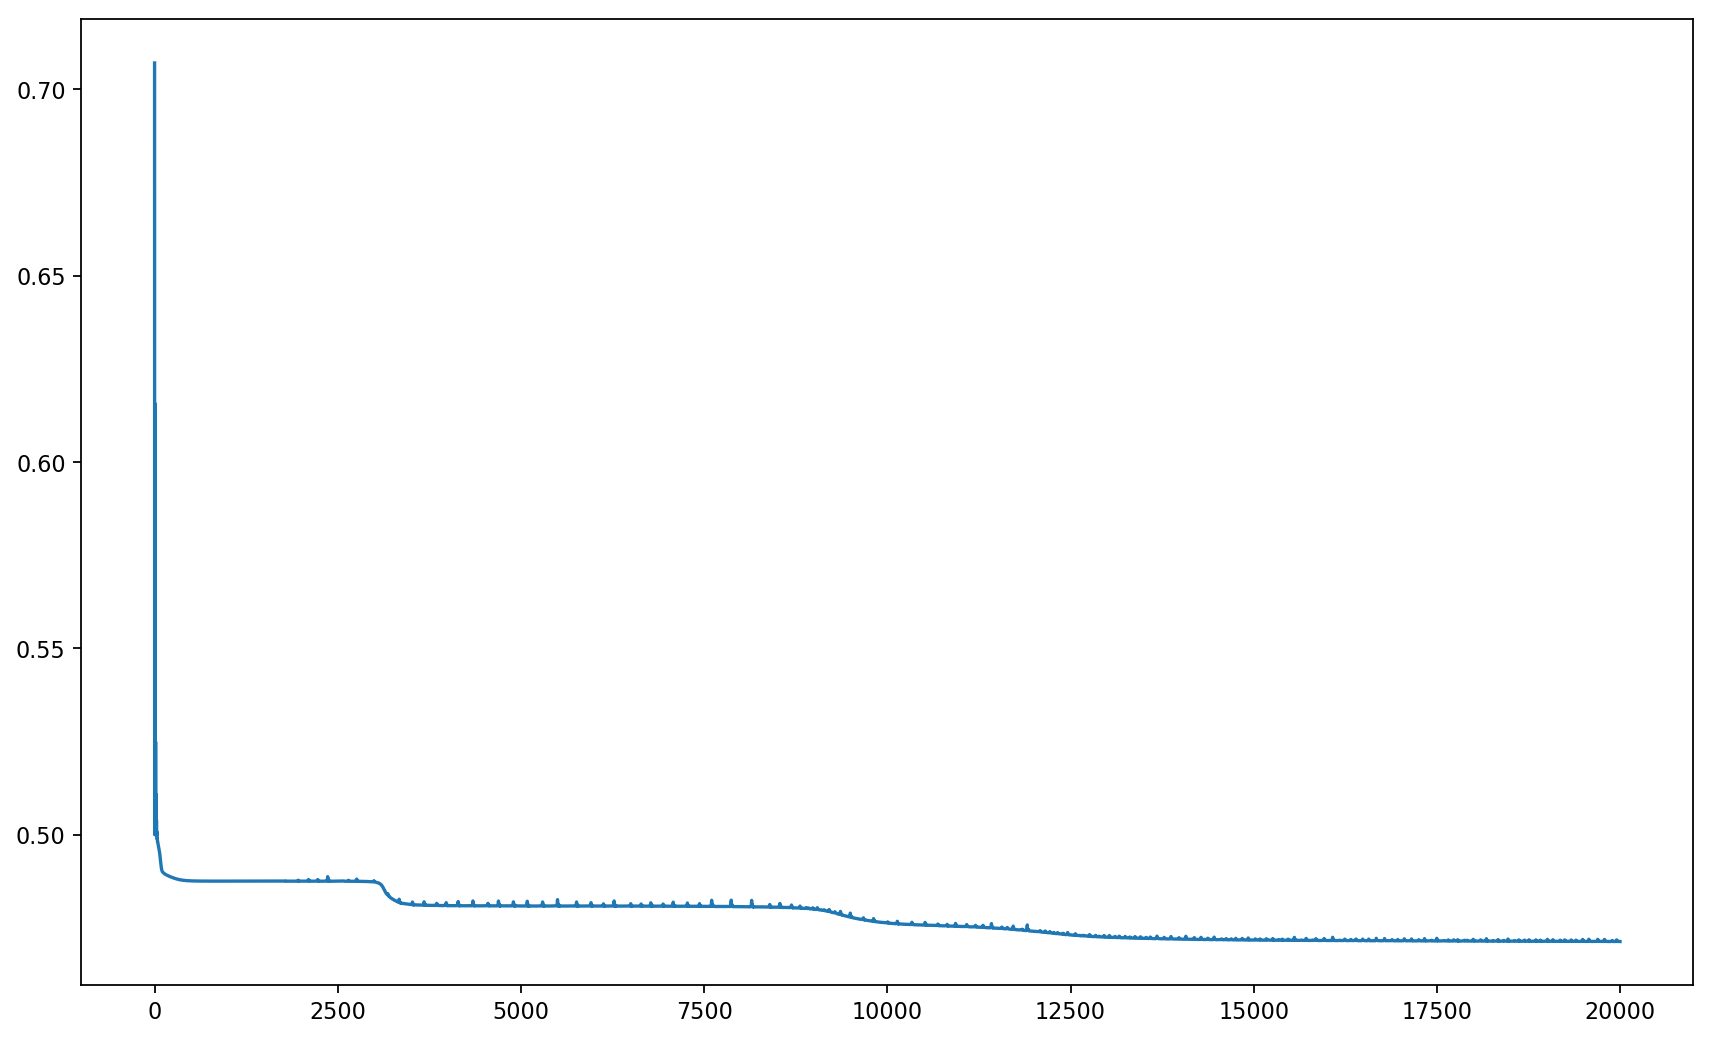

In [86]:
import matplotlib.pyplot as plt
import numpy as np

xs_train = [x[0] for x in list_train_loss]
ys_train = [x[1] for x in list_train_loss]

fig=plt.figure(figsize=(13, 8), dpi= 160, facecolor='w', edgecolor='k')

plt.plot((xs_train), ys_train)
#plt.xscale('log')
#plt.yscale('log')
#model.load_state_dict(state)

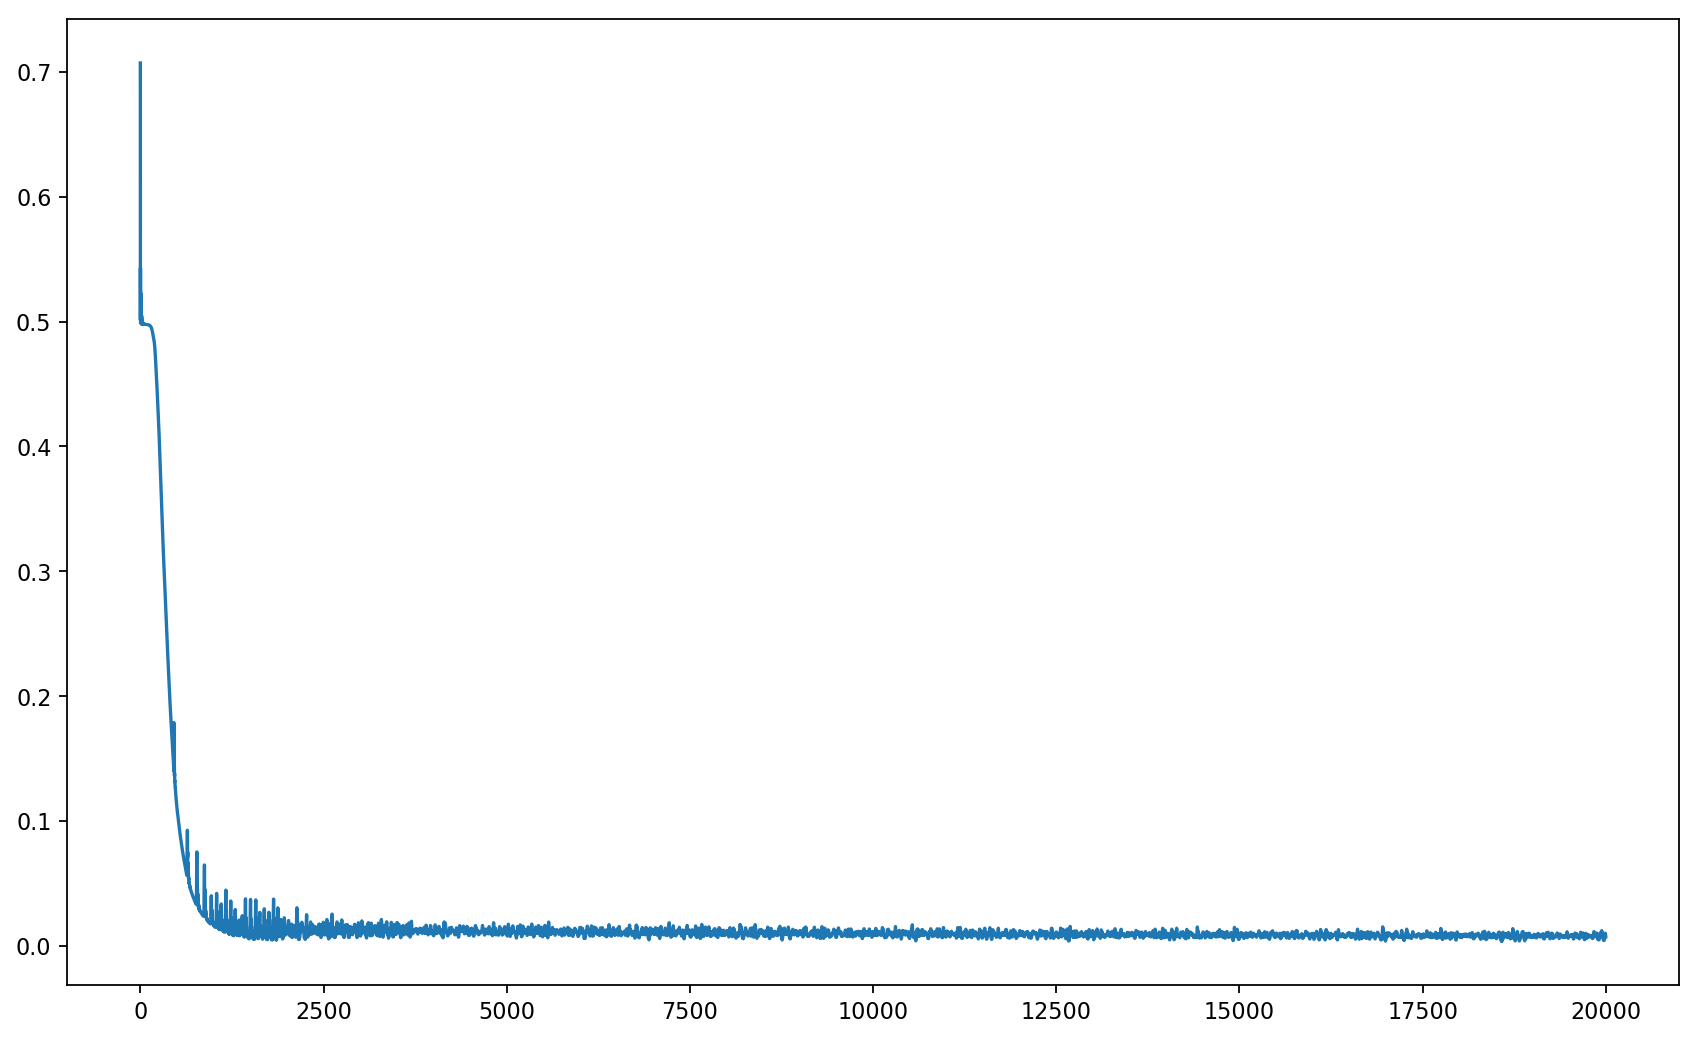

In [80]:
import matplotlib.pyplot as plt
import numpy as np

xs_train = [x[0] for x in list_train_loss]
ys_train = [x[1] for x in list_train_loss]

fig=plt.figure(figsize=(13, 8), dpi= 160, facecolor='w', edgecolor='k')

plt.plot((xs_train), ys_train)
#plt.xscale('log')
#plt.yscale('log')
#model.load_state_dict(state)

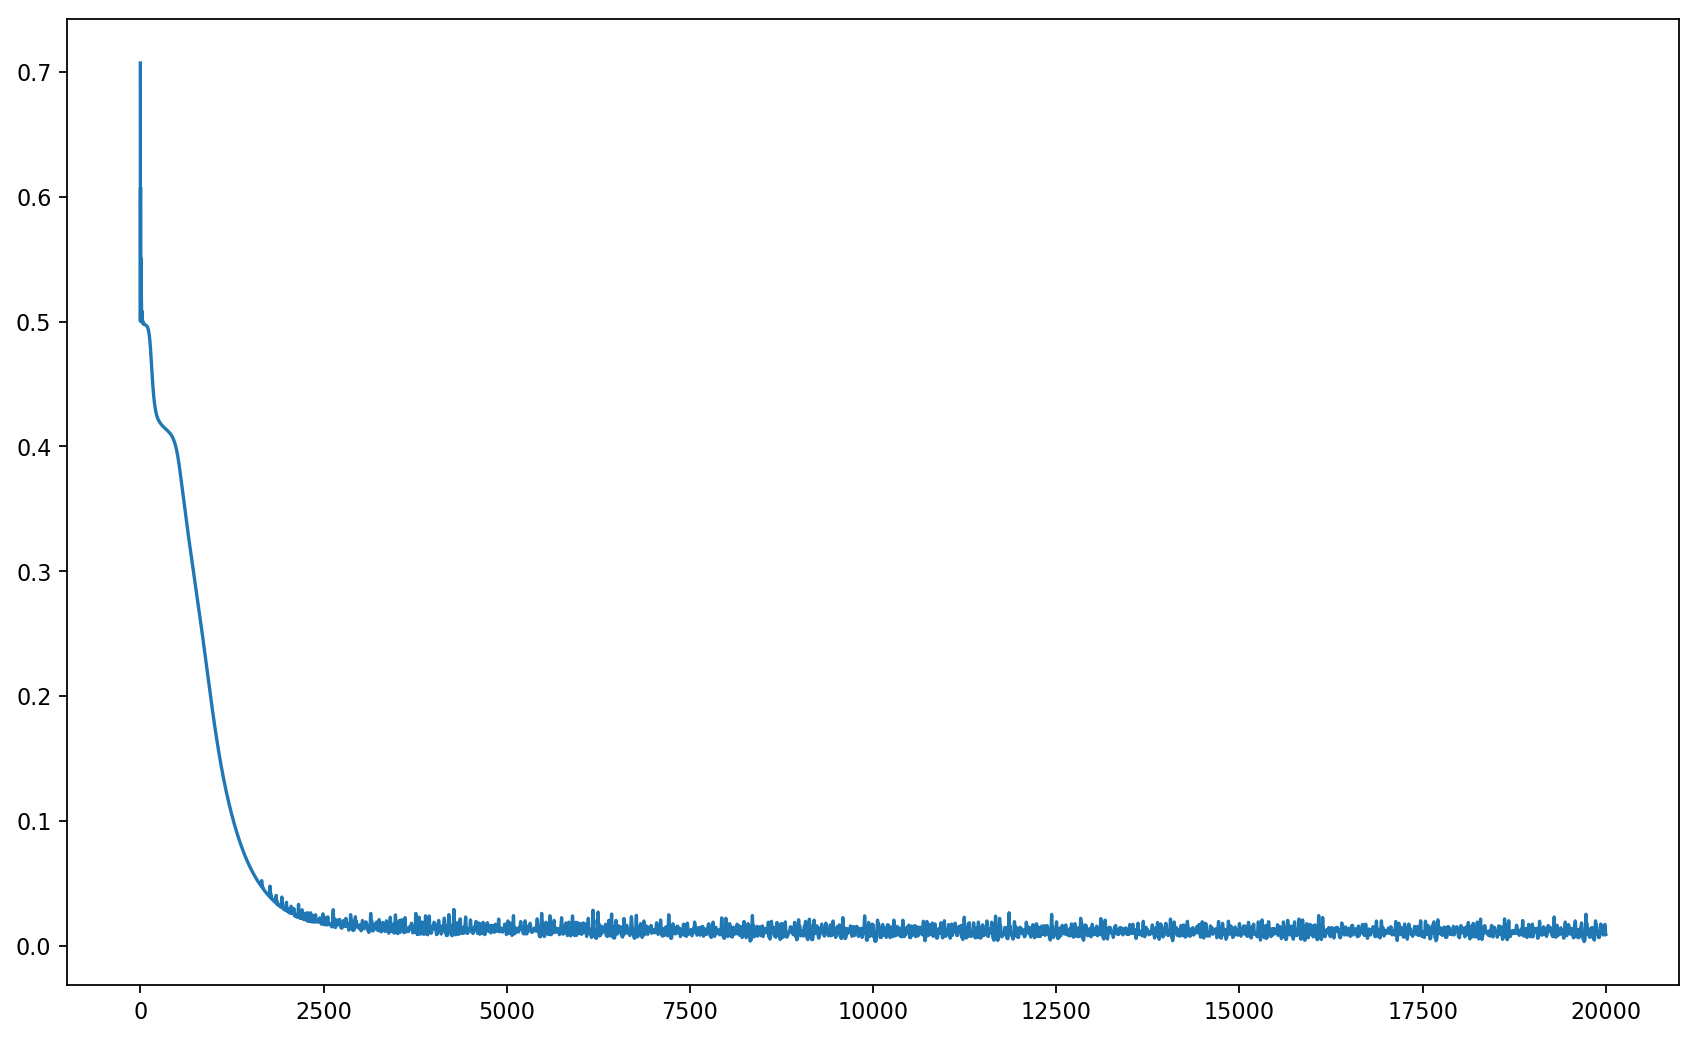

In [73]:
import matplotlib.pyplot as plt
import numpy as np

xs_train = [x[0] for x in list_train_loss]
ys_train = [x[1] for x in list_train_loss]

fig=plt.figure(figsize=(13, 8), dpi= 160, facecolor='w', edgecolor='k')

plt.plot((xs_train), ys_train)
#plt.xscale('log')
#plt.yscale('log')
#model.load_state_dict(state)